In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

from StatTools.experimental.augmentation.perturbations import (
    add_noise,
    add_poisson_gaps,
)
from StatTools.experimental.analysis.tools import get_extra_h_dfa
from StatTools.experimental.synthesis.tools import (
    adjust_hurst_to_range,
    reverse_hurst_adjustment,
)
from kalman_experiments import (
    get_signal,
    get_r_list,
    apply_kalman_filter,
    apply_kalman_filter_cached
)

### Experimental variables

| Variable              | Value                                     |
|-------------------------|----------------------------------------------|
| $ H $                 | $1/2$ to $3.5$, step is $1/4$              |
| Length of the forming filter, s   | open length |
| Order of the Kalman filter, r   | 2, 4, 8                                          |
| SNR     | $0.5, 1, 2$  |

In [2]:
H_LIST = np.arange(0.5, 3.75, 0.25)
TRJ_LEN_POW = 14
TRJ_LEN = 2**TRJ_LEN_POW

In [3]:
markers = [
    "o",  # circle
    "s",  # square
    "p",  # pentagon
    "v",  # triangle_down
    "<",  # triangle_left
    ">",  # triangle_right
    "^",  # triangle_up
    "*",  # star
    "h",  # hexagon
]

axis_fontsize = 14
label_fontsize = 14
legend_fontsize = 14
title_fontsize = 16

In [4]:
output_path = Path("./out")
kalman_cache_folder = Path("/home/jovyan/git/FluctuationAnalysisTools/filter_matrices")

## Signal synthesis

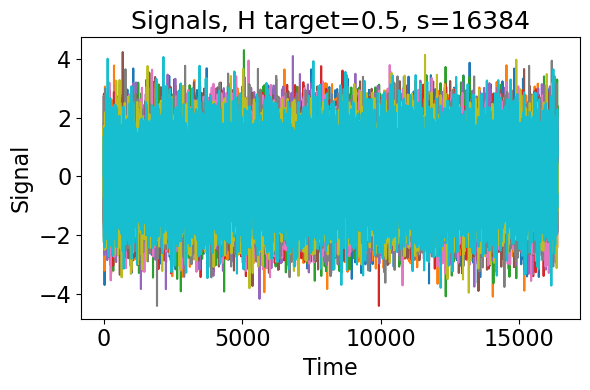

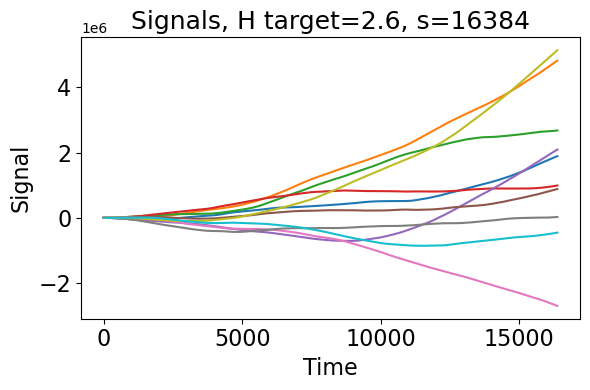

In [11]:
h = 0.5
s = TRJ_LEN
plt.figure(figsize=(6, 4))
for _ in range(10):
    signal = get_signal(h, TRJ_LEN, s)
    plt.plot(signal)

plt.title(f"Signals, H target={h}, s={s}", fontdict={"fontsize": 18})
plt.xlabel("Time", fontsize=16)
plt.ylabel("Signal", fontsize=16)
plt.tick_params(labelsize=16)
plt.tight_layout()
# plt.savefig(f"./out/signals_{h}.svg")
plt.show()

h = 2.6
s = TRJ_LEN
plt.figure(figsize=(6, 4))
for _ in range(10):
    signal = get_signal(h, TRJ_LEN, s)
    plt.plot(signal)

plt.title(f"Signals, H target={h}, s={s}", fontdict={"fontsize": 18})
plt.xlabel("Time", fontsize=16)
plt.ylabel("Signal", fontsize=16)
plt.tick_params(labelsize=16)
plt.tight_layout()
# plt.savefig(f"./out/signals_{h}.svg")
plt.show()

## Estimation of the synthesis error

In [11]:
test_df = pd.DataFrame(
    columns=[
        "H_target",
        "H_signal",
        "signal_len",
        "s",
    ]
)

In [15]:
s = TRJ_LEN
for h in H_LIST:
    for _ in tqdm(range(15)):
        signal = get_signal(h, TRJ_LEN, s)
        h_signal = get_extra_h_dfa(signal)
        test_df.loc[len(test_df)] = [
            h,
            h_signal,
            len(signal),
            s,
        ]

  0%|          | 0/15 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
  7%|▋         | 1/15 [00:02<00:37,  2.66s/it]/opt/conda/lib/python3.11/site-packages/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
 13%|█▎        | 2/15 [00:05<00:34,  2.68s/it]/opt/conda/lib/python3.11/site-packages/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
 20%|██        | 3/15 [00:08<00:32,  2.69s/it]/opt/conda/lib/python3.11/site-packages/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
 27%|██▋       | 4/15 [00:10<00:29,  2.70s/it]/opt/conda/lib/python3.11/site-packages/StatTools/gene

In [16]:
test_df["H_gen_diff"] = abs(test_df["H_target"] - test_df["H_signal"])

In [17]:
test_df

H_target  H_signal  signal_len        s  H_gen_diff
0         0.5  0.471656     16384.0  16384.0    0.028344
1         0.5  0.504204     16384.0  16384.0    0.004204
2         0.5  0.509779     16384.0  16384.0    0.009779
3         0.5  0.513498     16384.0  16384.0    0.013498
4         0.5  0.526140     16384.0  16384.0    0.026140
..        ...       ...         ...      ...         ...
261       3.5  3.496047     16384.0  16384.0    0.003953
262       3.5  3.489703     16384.0  16384.0    0.010297
263       3.5  3.488679     16384.0  16384.0    0.011321
264       3.5  3.463679     16384.0  16384.0    0.036321
265       3.5  3.507813     16384.0  16384.0    0.007813

[266 rows x 5 columns]

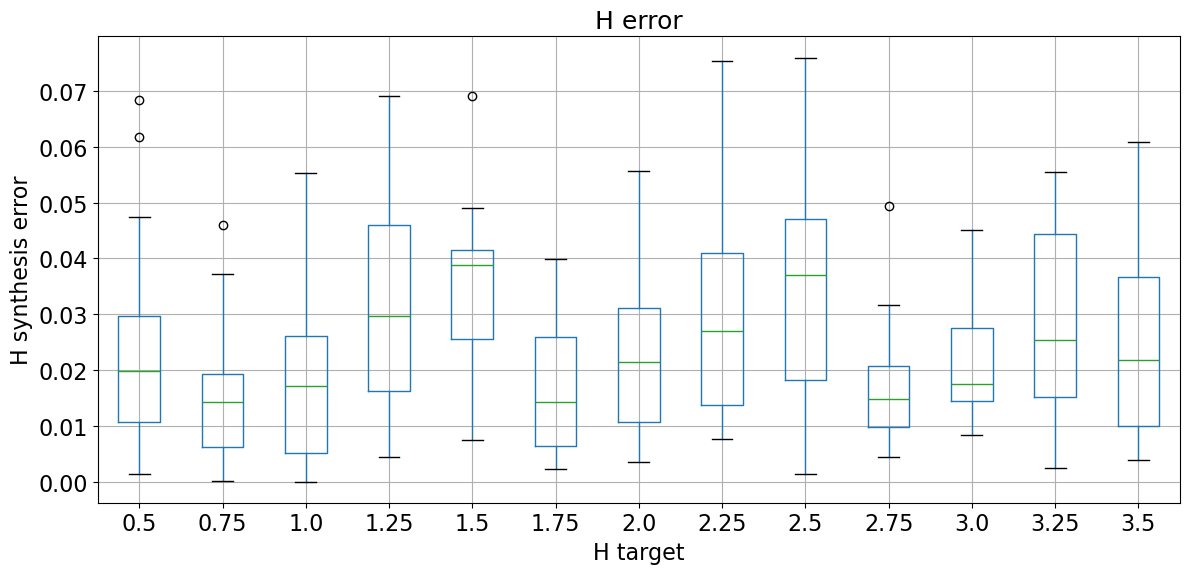

In [19]:
ax = test_df.boxplot(column="H_gen_diff", by="H_target", figsize=(12, 6))
plt.title("H error", fontdict={"fontsize": 18})
plt.suptitle("")
plt.xlabel("H target", fontsize=16)
plt.ylabel("H synthesis error", fontsize=16)
plt.tick_params(labelsize=16)
plt.tight_layout()
plt.savefig("./out/H_synthesis_error.svg")
plt.show()

## Experiment-Synthetics

### Gaps

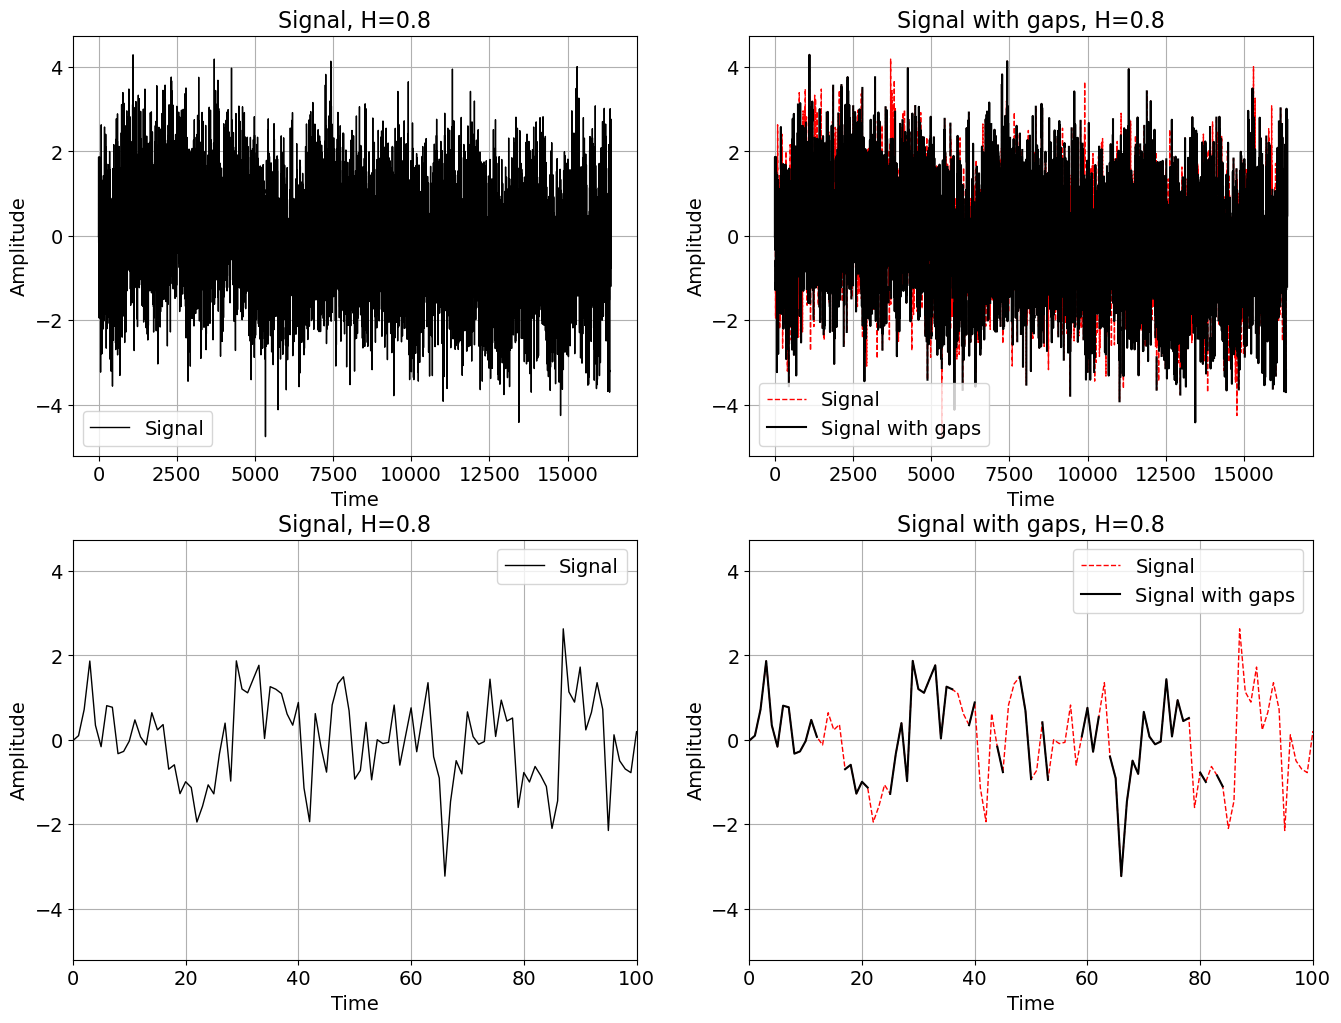

In [20]:
s = TRJ_LEN
h = 0.8
generated_signal = get_signal(h, TRJ_LEN, s)
gap_rate = 0.2
length_rate = 2.0
gaps_signal, gaps = add_poisson_gaps(generated_signal, gap_rate, length_rate)

plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
plt.plot(generated_signal, label="Signal", color="black", linewidth=1)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.tick_params(labelsize=label_fontsize)
plt.grid(True)
plt.title(f"Signal, H={h}", fontdict={"fontsize": title_fontsize})

plt.subplot(2, 2, 2)
plt.plot(
    generated_signal,
    label="Signal",
    color="red",
    linestyle="--",
    linewidth=1,
)
plt.plot(gaps_signal, label="Signal with gaps", color="black")
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.tick_params(labelsize=label_fontsize)
plt.grid(True)
plt.title(f"Signal with gaps, H={h}", fontdict={"fontsize": title_fontsize})

plt.subplot(2, 2, 3)
plt.plot(generated_signal, label="Signal", color="black", linewidth=1)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.tick_params(labelsize=label_fontsize)
plt.xlim(0, 100)
plt.grid(True)
plt.title(f"Signal, H={h}", fontdict={"fontsize": title_fontsize})

plt.subplot(2, 2, 4)
plt.plot(
    generated_signal,
    label="Signal",
    color="red",
    linestyle="--",
    linewidth=1,
)
plt.plot(gaps_signal, label="Signal with gaps", color="black")
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.tick_params(labelsize=label_fontsize)
plt.grid(True)
plt.xlim(0, 100)
plt.title(f"Signal with gaps, H={h}", fontdict={"fontsize": title_fontsize})
plt.show()


In [21]:
metrics_df = pd.DataFrame(
    columns=[
        "H_target",
        "H_signal",
        "H_estimated",
        "signal_len",
        "s",
        "r",
        "gap_rate",
        "length_rate",
        "SE",
    ]
)

ValueError: cannot set a row with mismatched columns

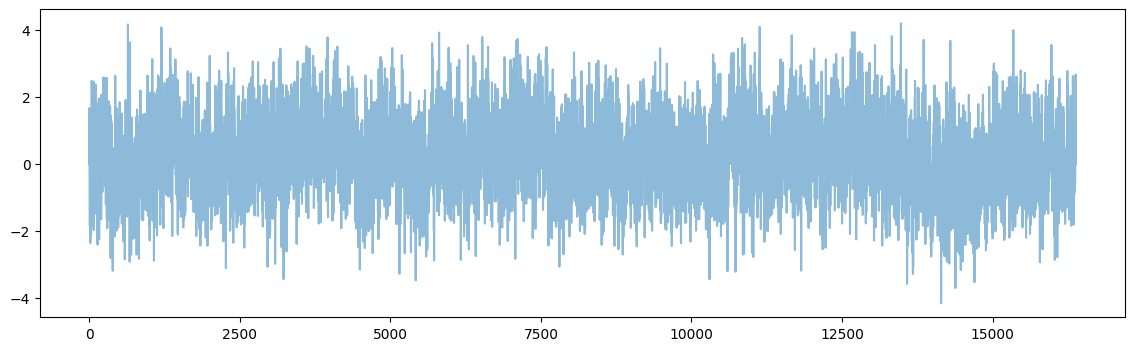

In [9]:
# one process version with plot
s = TRJ_LEN
axis_fontsize = 14
label_fontsize = 14
legend_fontsize = 14
title_fontsize = 16
n = 1
gap_rate = 0.2
length_rate = 2.0
for h in H_LIST[0:9]:
    se_dict = {}
    for r in get_r_list():
        se_dict[r] = []

    for i in range(n):
        signal = get_signal(h, TRJ_LEN, s, normalize=False)
        if i == 0:
            plt.figure(figsize=(14, 4))
        new_signal = signal
        if get_extra_h_dfa(signal) > 1.5:
            new_signal = np.diff(signal)
        gaps_signal, _ = add_poisson_gaps(generated_signal, gap_rate, length_rate)

        r_list = get_r_list()
        h_s = get_extra_h_dfa(signal)
        for r in r_list:
            estimated_signal = apply_kalman_filter(gaps_signal, h, r)
            if get_extra_h_dfa(signal) > 1.5:
                estimated_signal = np.cumsum(estimated_signal)

            se = np.nanstd(signal[0 : len(estimated_signal)] - estimated_signal)
            se_dict[r].append(se)

            h_est = get_extra_h_dfa(estimated_signal)
            if i == 0:
                plt.plot(
                    estimated_signal,
                    label=f"Filter output ({r}), SE={se:.3f}, Hs={h_s:.2f}, He={h_est:.2f}",
                    alpha=0.5,
                )

            metrics_df.loc[len(metrics_df)] = [
                h,
                h_s,
                h_est,
                len(signal),
                s,
                r,
                gap_rate,
                length_rate,
                se,
            ]

        if i == 0:
            plt.plot(
                signal,
                label="Signal",
                color="red",
                alpha=0.5,
                linewidth=1,
            )
            plt.xlabel("Time", fontsize=axis_fontsize)
            plt.ylabel("Amplitude", fontsize=axis_fontsize)
            # plt.xlim(2000, 2100)
            plt.legend(fontsize=legend_fontsize)
            plt.tick_params(labelsize=label_fontsize)
            plt.title(
                f"Result of the filtering, $\\hat{{H}}=${h}, gaps length rate={length_rate}",
                fontdict={"fontsize": title_fontsize},
            )
            plt.grid(True)
            plt.show()

    for k, v in se_dict.items():
        print(f"H={h}, SE (order {k}): {np.mean(v):.3f}+-{np.std(v):.3f}")

In [26]:
metrics_df.to_csv("./out/kalman-kasdin-gaps.csv", index=False)

#### Analysis

In [27]:
metrics_df = pd.read_csv("./out/kalman-kasdin-gaps.csv")
metrics_df.head()

H_target  H_signal  H_restored  signal_len        s    r  gap_rate  \
0      0.50  0.510208    0.746558     16384.0  16384.0  2.0       0.2   
1      0.50  0.510208    0.746558     16384.0  16384.0  4.0       0.2   
2      0.50  0.510208    0.746558     16384.0  16384.0  8.0       0.2   
3      0.75  0.734819    0.776782     16384.0  16384.0  2.0       0.2   
4      0.75  0.734819    0.790996     16384.0  16384.0  4.0       0.2   

   length_rate        SE  
0          2.0  1.395685  
1          2.0  1.395685  
2          2.0  1.395685  
3          2.0  1.456856  
4          2.0  1.468759

In [28]:
metrics_df["H_restore_diff"] = abs(metrics_df["H_signal"] - metrics_df["H_estimated"])
metrics_df["H_gen_diff"] = abs(metrics_df["H_target"] - metrics_df["H_signal"])

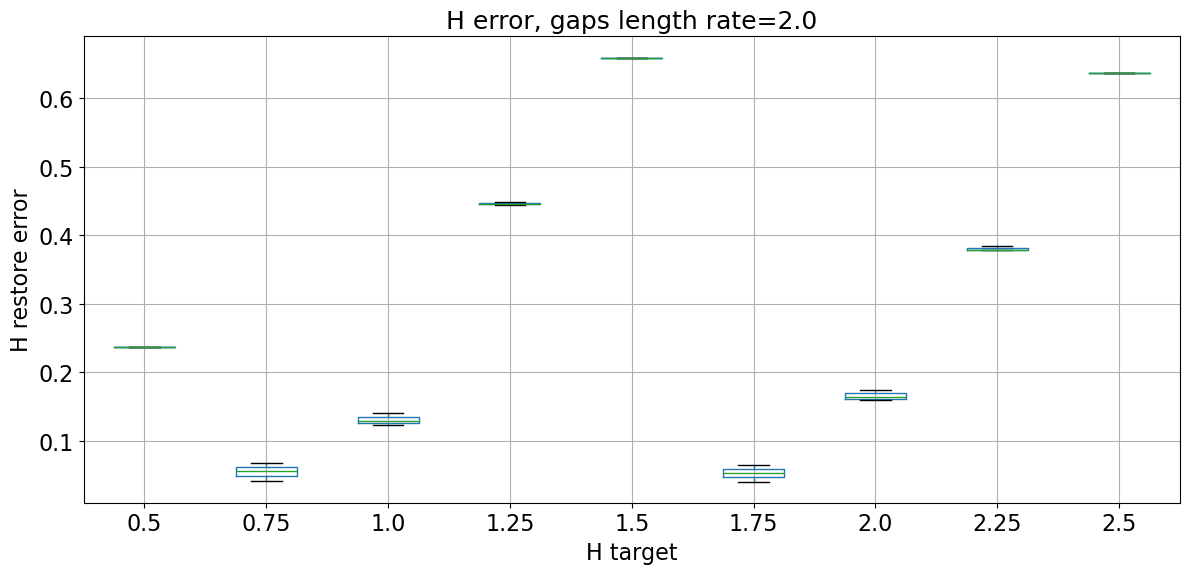

In [ ]:
for length_rate in metrics_df["length_rate"].unique():
    part_metrics_df = metrics_df[metrics_df["length_rate"] == length_rate]
    ax = part_metrics_df.boxplot(
        column="H_restore_diff", by="H_target", figsize=(12, 6)
    )
    plt.title(f"H error, gaps length rate={length_rate}", fontdict={"fontsize": 18})
    plt.suptitle("")
    plt.xlabel("H target", fontsize=16)
    plt.ylabel("H restore error", fontsize=16)
    plt.tick_params(labelsize=16)
    plt.tight_layout()
    plt.show()

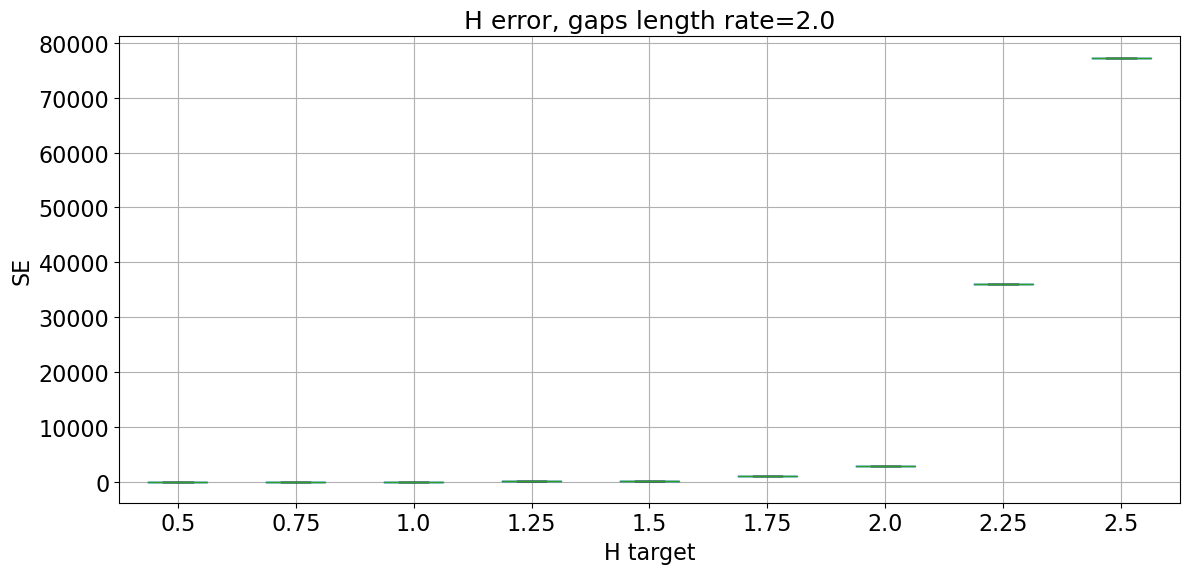

In [33]:
for length_rate in metrics_df["length_rate"].unique():
    part_metrics_df = metrics_df[metrics_df["length_rate"] == length_rate]
    ax = part_metrics_df.boxplot(column="SE", by="H_target", figsize=(12, 6))
    plt.title(f"H error, gaps length rate={length_rate}", fontdict={"fontsize": 18})
    plt.suptitle("")
    plt.xlabel("H target", fontsize=16)
    plt.ylabel("SE", fontsize=16)
    plt.tick_params(labelsize=16)
    plt.tight_layout()
    plt.show()

### Noise

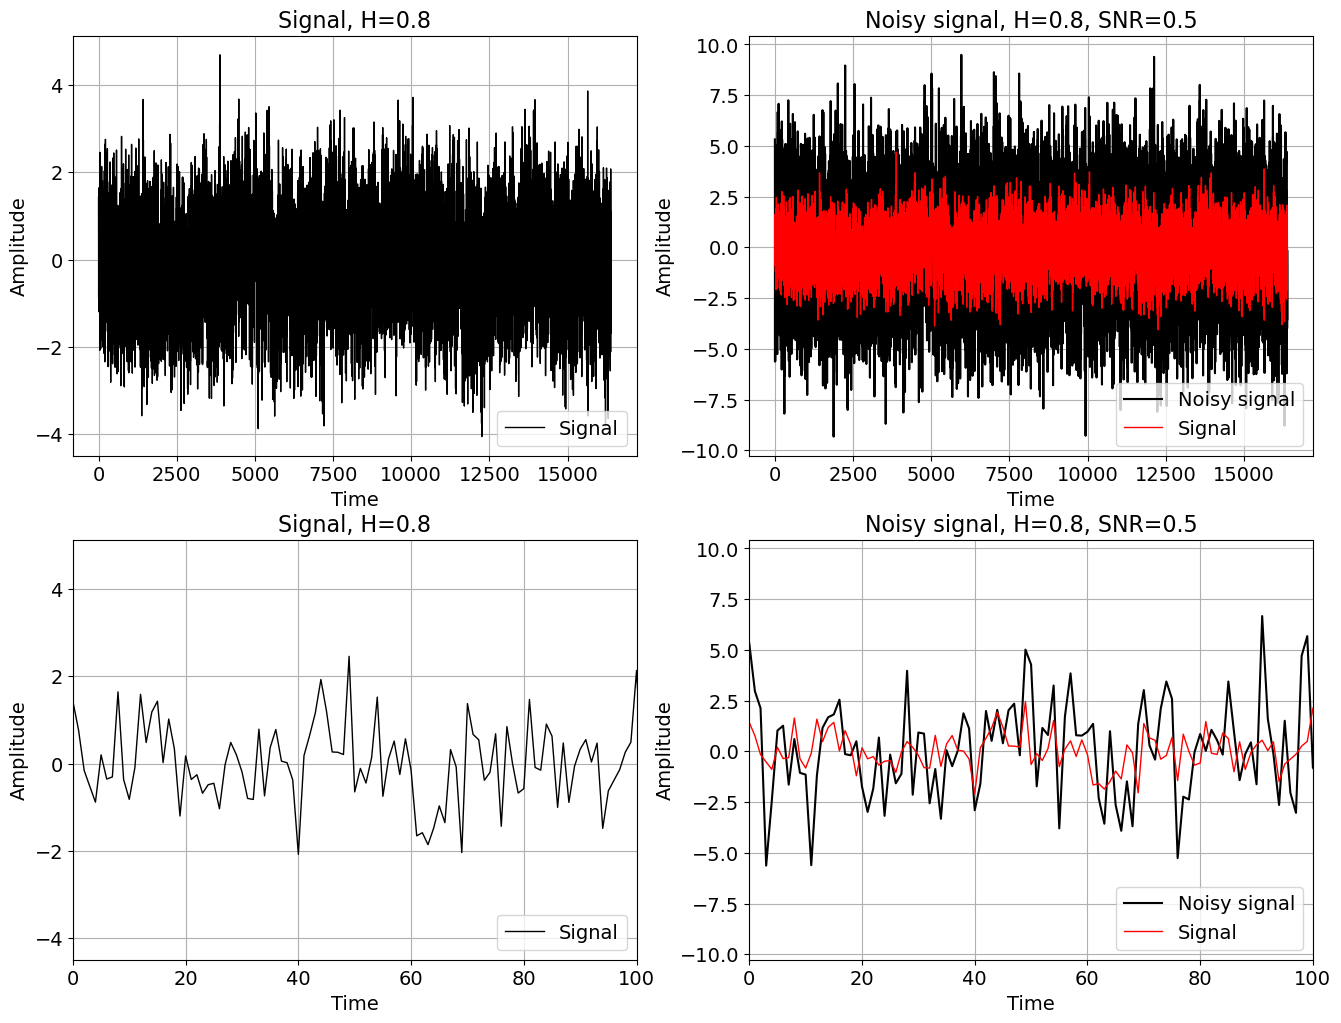

In [5]:
s = TRJ_LEN
h = 0.8
generated_signal = get_signal(h, TRJ_LEN, s)
snr = 0.5
noisy_signal, _ = add_noise(generated_signal, snr)

plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
plt.plot(generated_signal, label="Signal", color="black", linewidth=1)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize, loc="lower right")
plt.tick_params(labelsize=label_fontsize)
plt.grid(True)
plt.title(f"Signal, H={h}", fontdict={"fontsize": title_fontsize})

plt.subplot(2, 2, 2)
plt.plot(noisy_signal, label="Noisy signal", color="black")
plt.plot(
    generated_signal,
    label="Signal",
    color="red",
    linewidth=1,
)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize, loc="lower right")
plt.tick_params(labelsize=label_fontsize)
plt.grid(True)
plt.title(f"Noisy signal, H={h}, SNR={snr}", fontdict={"fontsize": title_fontsize})

plt.subplot(2, 2, 3)
plt.plot(generated_signal, label="Signal", color="black", linewidth=1)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize, loc="lower right")
plt.tick_params(labelsize=label_fontsize)
plt.xlim(0, 100)
plt.grid(True)
plt.title(f"Signal, H={h}", fontdict={"fontsize": title_fontsize})

plt.subplot(2, 2, 4)
plt.plot(noisy_signal, label="Noisy signal", color="black")
plt.plot(
    generated_signal,
    label="Signal",
    color="red",
    linewidth=1,
)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize, loc="lower right")
plt.tick_params(labelsize=label_fontsize)
plt.grid(True)
plt.xlim(0, 100)
plt.title(f"Noisy signal, H={h}, SNR={snr}", fontdict={"fontsize": title_fontsize})
plt.show()

In [6]:
metrics_df = pd.DataFrame(
    columns=[
        "H_target",
        "H_signal",
        "H_estimated",
        "signal_len",
        "s",
        "r",
        "SNR",
        "SE",
    ]
)

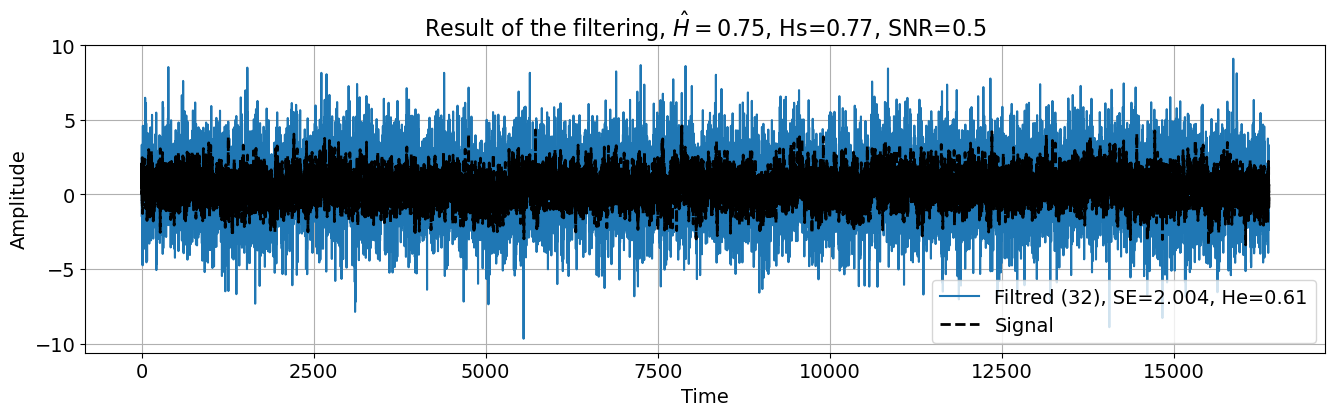

H=0.75, SNR=0.5, SE (order 2): nan+-nan
H=0.75, SNR=0.5, SE (order 4): nan+-nan
H=0.75, SNR=0.5, SE (order 8): nan+-nan
H=0.75, SNR=0.5, SE (order 16): nan+-nan
H=0.75, SNR=0.5, SE (order 32): 2.006+-0.002


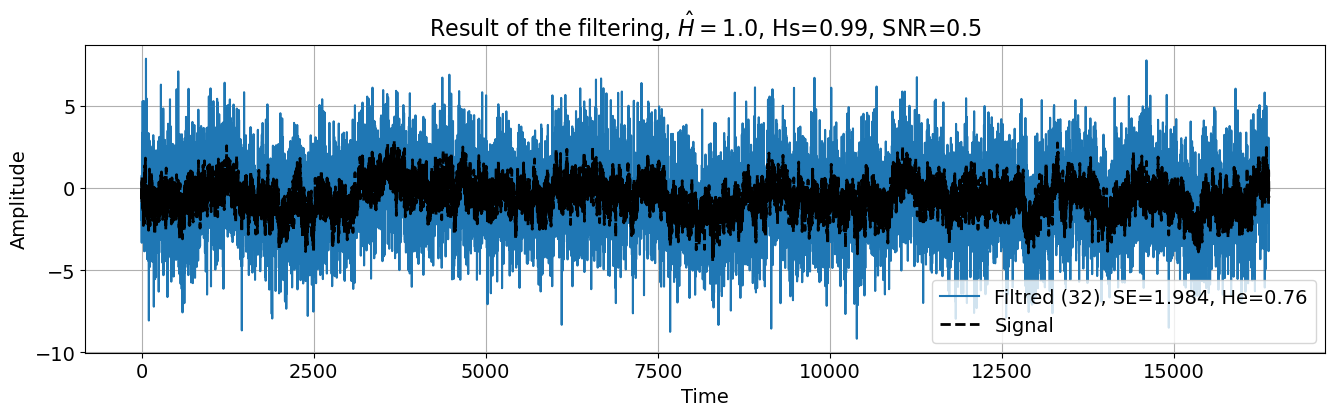

H=1.0, SNR=0.5, SE (order 2): nan+-nan
H=1.0, SNR=0.5, SE (order 4): nan+-nan
H=1.0, SNR=0.5, SE (order 8): nan+-nan
H=1.0, SNR=0.5, SE (order 16): nan+-nan
H=1.0, SNR=0.5, SE (order 32): 2.003+-0.019


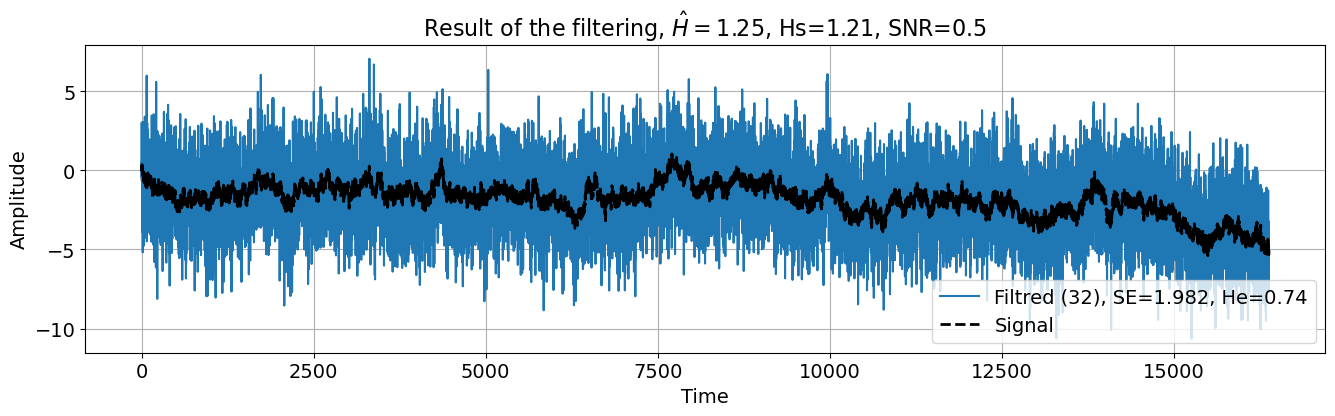

H=1.25, SNR=0.5, SE (order 2): nan+-nan
H=1.25, SNR=0.5, SE (order 4): nan+-nan
H=1.25, SNR=0.5, SE (order 8): nan+-nan
H=1.25, SNR=0.5, SE (order 16): nan+-nan
H=1.25, SNR=0.5, SE (order 32): 1.993+-0.011


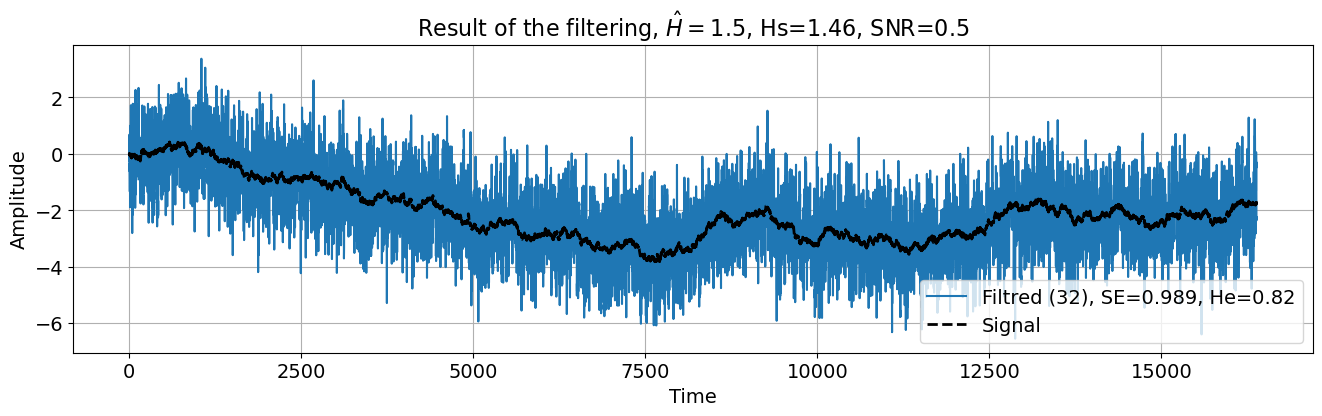

H=1.5, SNR=0.5, SE (order 2): nan+-nan
H=1.5, SNR=0.5, SE (order 4): nan+-nan
H=1.5, SNR=0.5, SE (order 8): nan+-nan
H=1.5, SNR=0.5, SE (order 16): nan+-nan
H=1.5, SNR=0.5, SE (order 32): 0.987+-0.002


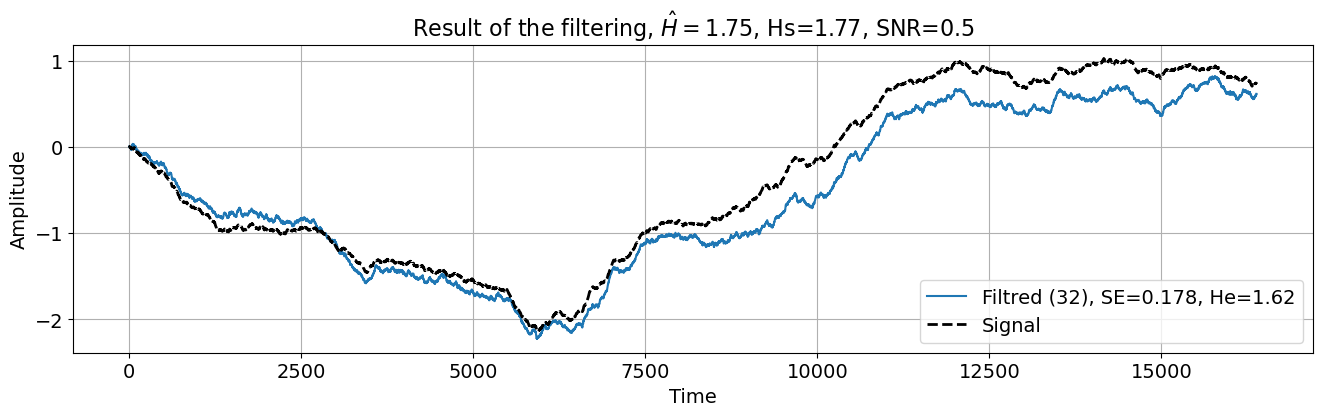

H=1.75, SNR=0.5, SE (order 2): nan+-nan
H=1.75, SNR=0.5, SE (order 4): nan+-nan
H=1.75, SNR=0.5, SE (order 8): nan+-nan
H=1.75, SNR=0.5, SE (order 16): nan+-nan
H=1.75, SNR=0.5, SE (order 32): 0.209+-0.032


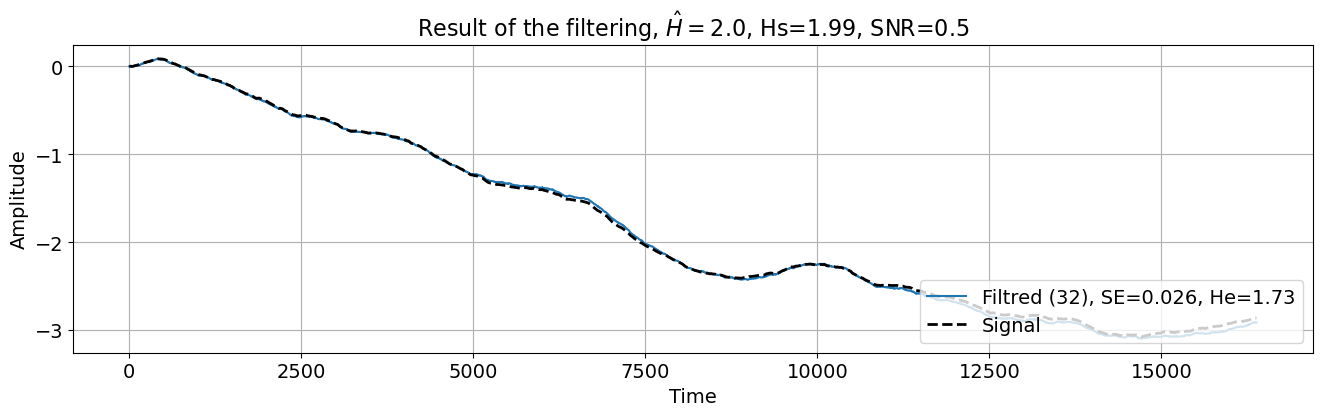

H=2.0, SNR=0.5, SE (order 2): nan+-nan
H=2.0, SNR=0.5, SE (order 4): nan+-nan
H=2.0, SNR=0.5, SE (order 8): nan+-nan
H=2.0, SNR=0.5, SE (order 16): nan+-nan
H=2.0, SNR=0.5, SE (order 32): 0.028+-0.002


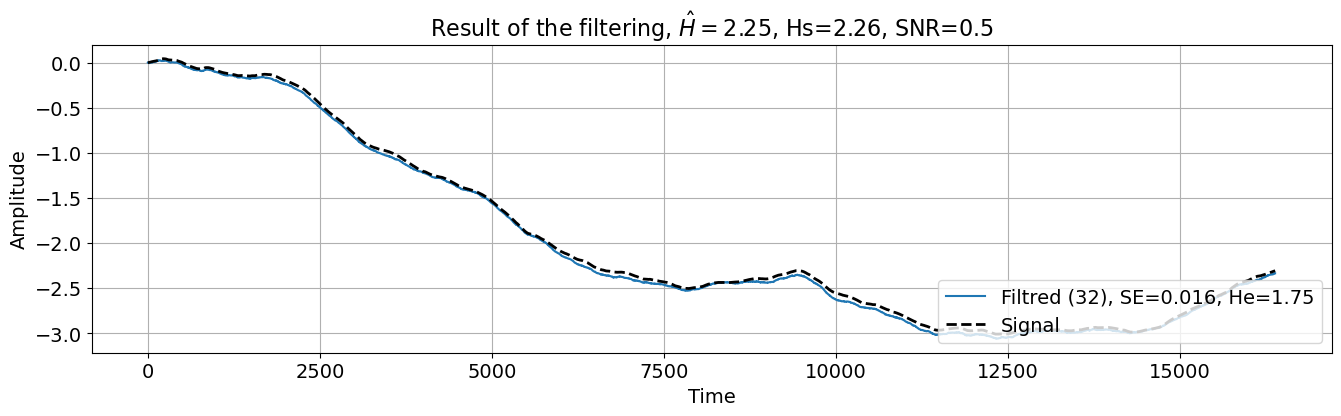

H=2.25, SNR=0.5, SE (order 2): nan+-nan
H=2.25, SNR=0.5, SE (order 4): nan+-nan
H=2.25, SNR=0.5, SE (order 8): nan+-nan
H=2.25, SNR=0.5, SE (order 16): nan+-nan
H=2.25, SNR=0.5, SE (order 32): 0.015+-0.002


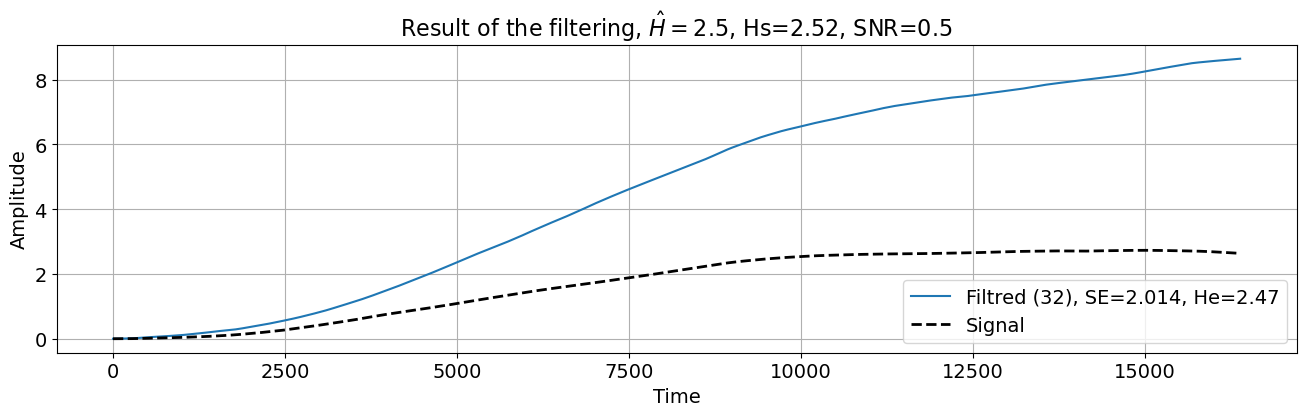

H=2.5, SNR=0.5, SE (order 2): nan+-nan
H=2.5, SNR=0.5, SE (order 4): nan+-nan
H=2.5, SNR=0.5, SE (order 8): nan+-nan
H=2.5, SNR=0.5, SE (order 16): nan+-nan
H=2.5, SNR=0.5, SE (order 32): 1.018+-0.996


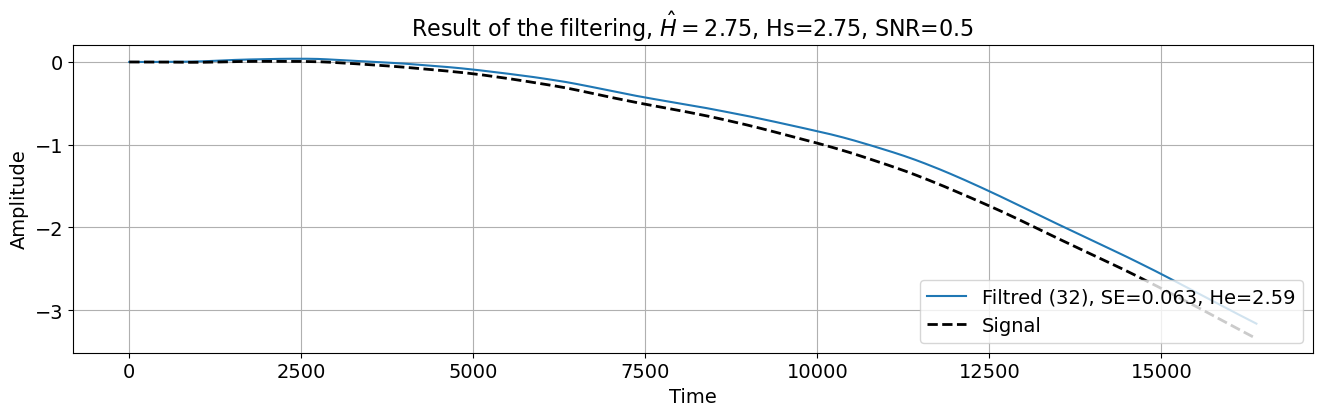

H=2.75, SNR=0.5, SE (order 2): nan+-nan
H=2.75, SNR=0.5, SE (order 4): nan+-nan
H=2.75, SNR=0.5, SE (order 8): nan+-nan
H=2.75, SNR=0.5, SE (order 16): nan+-nan
H=2.75, SNR=0.5, SE (order 32): 0.117+-0.054


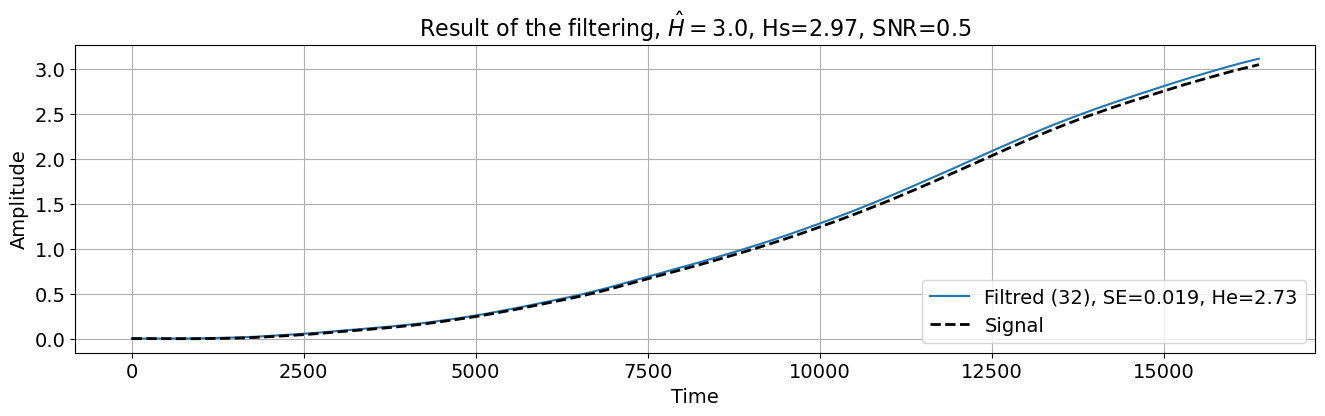

H=3.0, SNR=0.5, SE (order 2): nan+-nan
H=3.0, SNR=0.5, SE (order 4): nan+-nan
H=3.0, SNR=0.5, SE (order 8): nan+-nan
H=3.0, SNR=0.5, SE (order 16): nan+-nan
H=3.0, SNR=0.5, SE (order 32): 0.019+-0.000


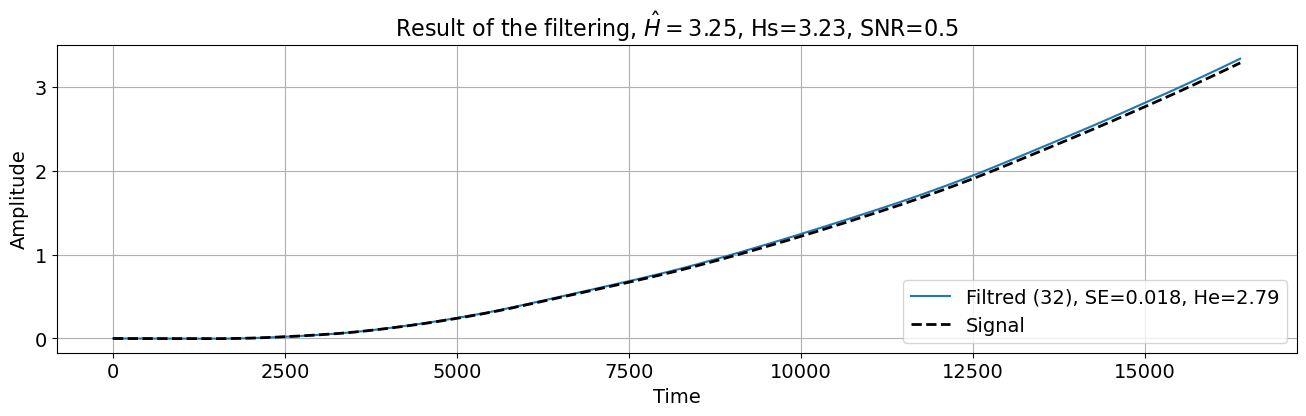

H=3.25, SNR=0.5, SE (order 2): nan+-nan
H=3.25, SNR=0.5, SE (order 4): nan+-nan
H=3.25, SNR=0.5, SE (order 8): nan+-nan
H=3.25, SNR=0.5, SE (order 16): nan+-nan
H=3.25, SNR=0.5, SE (order 32): 0.023+-0.006


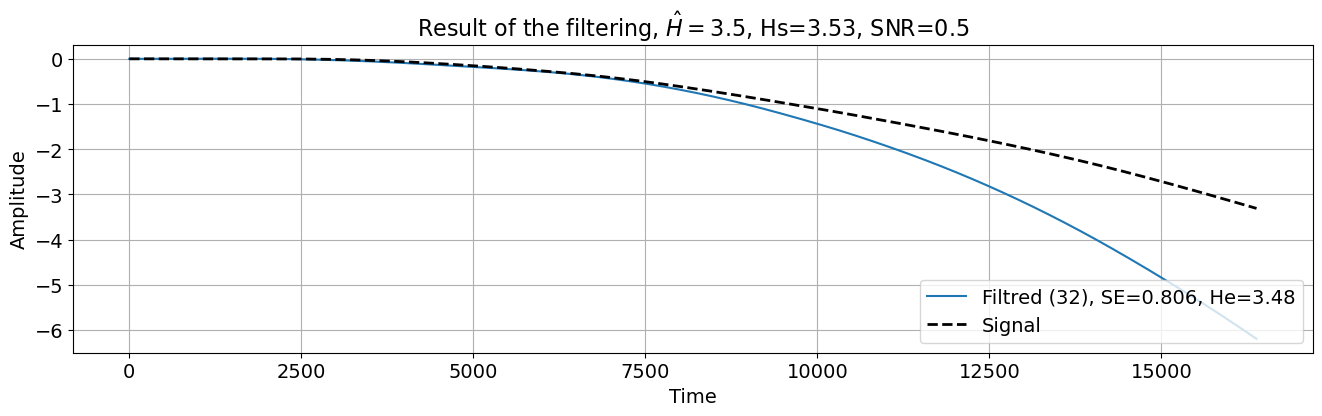

H=3.5, SNR=0.5, SE (order 2): nan+-nan
H=3.5, SNR=0.5, SE (order 4): nan+-nan
H=3.5, SNR=0.5, SE (order 8): nan+-nan
H=3.5, SNR=0.5, SE (order 16): nan+-nan
H=3.5, SNR=0.5, SE (order 32): 0.438+-0.369


In [7]:
# one process version with plot
s = TRJ_LEN
axis_fontsize = 14
label_fontsize = 14
legend_fontsize = 14
title_fontsize = 16
SNR_LIST = [0.5]
n = 2
for snr in SNR_LIST:
    for h in H_LIST[1:]:
        se_dict = {}
        for r in get_r_list():
            se_dict[r] = []
    
        for i in range(n):
            signal = get_signal(h, TRJ_LEN, s, normalize=False)
            signal -= np.mean(signal)
            signal /= np.std(signal)
            signal -= signal[0]
            if i == 0:
                plt.figure(figsize=(16, 4))
            adjusted_signal, applied_steps = adjust_hurst_to_range(signal)
            noisy_signal, noise = add_noise(adjusted_signal, ratio=snr)
            r_list = get_r_list()
            h_s = get_extra_h_dfa(signal)
            for r in [32]:
                estimated_signal = apply_kalman_filter_cached(noisy_signal, model_h=h, r=r, noise=noise, cache_folder=kalman_cache_folder)
                estimated_signal = reverse_hurst_adjustment(estimated_signal, applied_steps)
                se = np.nanstd(signal[0 : len(estimated_signal)] - estimated_signal)
                se_dict[r].append(se)
    
                h_est = get_extra_h_dfa(estimated_signal)
                if i == 0:
                    plt.plot(
                        estimated_signal,
                        label=f"Filtred ({r}), SE={se:.3f}, He={h_est:.2f}",
                        # alpha=0.5,
                    )
    
                metrics_df.loc[len(metrics_df)] = [
                    h,
                    h_s,
                    h_est,
                    len(signal),
                    s,
                    r,
                    snr,
                    se,
                ]
    
            if i == 0:
                plt.plot(
                    signal,
                    label="Signal",
                    color="black",
                    linestyle="--",
                    # alpha=0.5,
                    linewidth=2,
                )
                plt.xlabel("Time", fontsize=axis_fontsize)
                plt.ylabel("Amplitude", fontsize=axis_fontsize)
                # plt.xlim(2000, 2200)
                plt.legend(fontsize=legend_fontsize, loc="lower right")
                plt.tick_params(labelsize=label_fontsize)
                plt.title(
                    f"Result of the filtering, $\\hat{{H}}=${h}, Hs={h_s:.2f}, SNR={snr}",
                    fontdict={"fontsize": title_fontsize},
                )
                plt.grid(True)
                plt.show()
    
        for k, v in se_dict.items():
            print(f"H={h}, SNR={snr}, SE (order {k}): {np.mean(v):.3f}+-{np.std(v):.3f}")

In [8]:
metrics_df.to_csv(output_path / "kalman-kasdin-noise.csv", index=False)

#### Analysis

In [25]:
# metrics_df = pd.read_csv(output_path / "kalman-kasdin-noise.csv")
metrics_df = pd.read_csv(Path("/home/jovyan/git/FluctuationAnalysisTools/kalman-32.csv"))
metrics_df.head()

H_target  H_signal  H_estimated  signal_len        s     r  SNR        SE  \
0      0.75  0.762011     0.613771     16384.0  16384.0  32.0  0.5  0.894916   
1      0.75  0.762011     0.613771     16384.0  16384.0  32.0  0.5  1.999398   
2      0.75  0.762011     0.613771     16384.0  16384.0  32.0  0.5  1.999398   
3      0.75  0.762011     0.613771     16384.0  16384.0  32.0  0.5  1.999398   
4      0.75  0.762011     0.781055     16384.0  16384.0  32.0  0.5  1.149892   

   H_kalman  
0      0.50  
1      0.75  
2      1.00  
3      1.25  
4      1.50

In [26]:
metrics_df["H_restore_diff"] = abs(metrics_df["H_signal"] - metrics_df["H_estimated"])
metrics_df["H_gen_diff"] = abs(metrics_df["H_target"] - metrics_df["H_signal"])

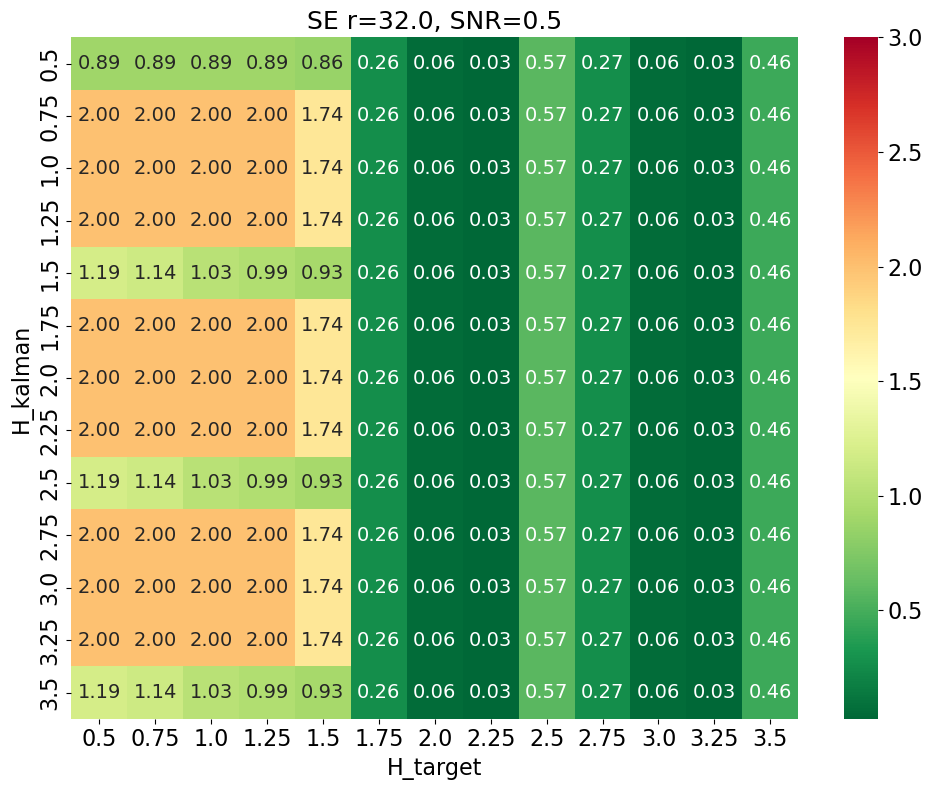

In [32]:
for r in metrics_df["r"].unique():
    filtered_df = metrics_df[metrics_df["r"] == r]
    snr = filtered_df["SNR"][0]

    heatmap_data = filtered_df.groupby(["H_kalman", "H_target"])["SE"].mean().reset_index()
    pivot_table = heatmap_data.pivot(index="H_kalman", columns="H_target", values="SE")

    colors = ["forestgreen", "steelblue", "indianred"]
    cmap = LinearSegmentedColormap.from_list("red_blue_green", colors, N=30)
    cmap = "RdYlGn_r"

    # Создаем heatmap
    plt.figure(figsize=(10, 8))
    annotations = pivot_table.map(lambda x: "5+" if x > 5 else f"{x:.2f}")

    ax = sns.heatmap(
        pivot_table,
        annot=annotations,
        annot_kws={"fontsize": 14},
        fmt="",
        cmap=cmap,
        vmax=3,
    )
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=16)
    plt.title(f"SE r={r}, SNR={snr}", fontdict={"fontsize": 18})
    plt.xlabel("H_target", fontsize=16)
    plt.ylabel("H_kalman", fontsize=16)
    plt.tick_params(labelsize=16)
    plt.tight_layout()
    # plt.savefig(f"research/out/RMSE_heatmap_{H}.svg")
    plt.show()

In [31]:
pivot_table

H_target      0.50      0.75      1.00      1.25      1.50      1.75  \
H_kalman                                                               
0.50      0.894360  0.894496  0.893792  0.892555  0.858220  0.260602   
0.75      1.995029  1.995029  1.995029  1.995029  1.738772  0.260615   
1.00      1.995029  1.995029  1.995029  1.995029  1.738772  0.260615   
1.25      1.995029  1.995029  1.995029  1.995029  1.738772  0.260615   
1.50      1.194701  1.144803  1.034493  0.986250  0.930359  0.260615   
1.75      1.995029  1.995029  1.995029  1.995029  1.738772  0.260615   
2.00      1.995029  1.995029  1.995029  1.995029  1.738772  0.260615   
2.25      1.995029  1.995029  1.995029  1.995029  1.738772  0.260615   
2.50      1.194701  1.144803  1.034493  0.986250  0.930359  0.260615   
2.75      1.995029  1.995029  1.995029  1.995029  1.738772  0.260615   
3.00      1.995029  1.995029  1.995029  1.995029  1.738772  0.260615   
3.25      1.995029  1.995029  1.995029  1.995029  1.738772  0.260615   
3.50      1.194701  1.144803  1.034493  0.986250  0.930359  0.260615   

H_target      2.00      2.25      2.50      2.75      3.00      3.25     3.50  
H_kalman                                                                       
0.50      0.056565  0.027287  0.574168  0.268911  0.055651  0.030304  0.46391  
0.75      0.056565  0.027287  0.574168  0.268911  0.055651  0.030304  0.46391  
1.00      0.056565  0.027287  0.574168  0.268911  0.055651  0.030304  0.46391  
1.25      0.056565  0.027287  0.574168  0.268911  0.055651  0.030304  0.46391  
1.50      0.056565  0.027287  0.574168  0.268911  0.055651  0.030304  0.46391  
1.75      0.056565  0.027287  0.574168  0.268911  0.055651  0.030304  0.46391  
2.00      0.056565  0.027287  0.574168  0.268911  0.055651  0.030304  0.46391  
2.25      0.056565  0.027287  0.574168  0.268911  0.055651  0.030304  0.46391  
2.50      0.056565  0.027287  0.574168  0.268911  0.055651  0.030304  0.46391  
2.75      0.056565  0.027287  0.574168  0.268911  0.055651  0.030304  0.46391  
3.00      0.056565  0.027287  0.574168  0.268911  0.055651  0.030304  0.46391  
3.25      0.056565  0.027287  0.574168  0.268911  0.055651  0.030304  0.46391  
3.50      0.056565  0.027287  0.574168  0.268911  0.055651  0.030304  0.46391

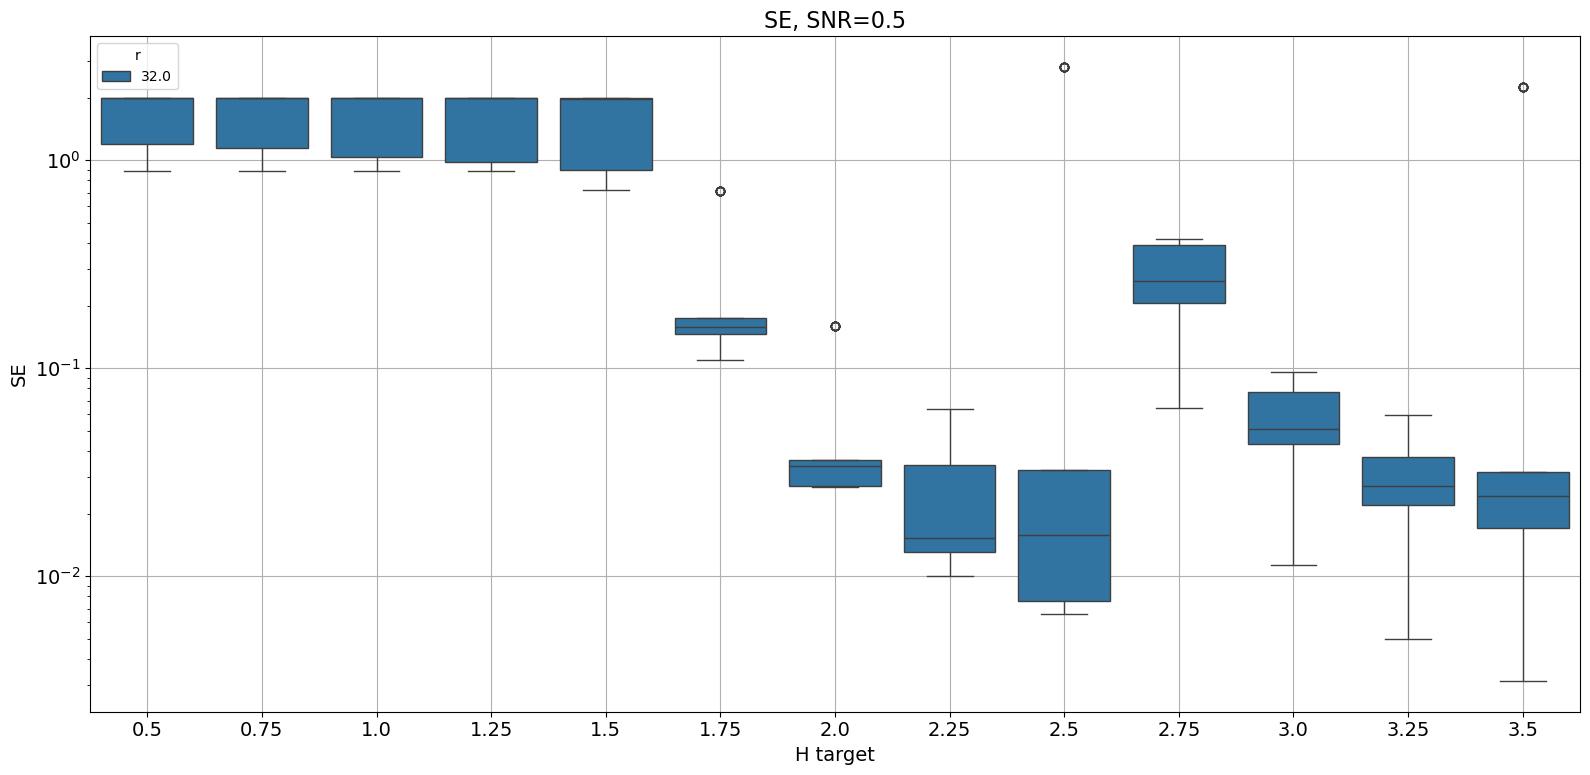

In [28]:
for snr in metrics_df["SNR"].unique():
    plt.figure(figsize=(16, 8))

    part_metrics_df = metrics_df[metrics_df["SNR"] == snr]

    sns.boxplot(x='H_target', y='SE', hue='r',  data=part_metrics_df, palette='tab10') #sns.color_palette("tab10")
    plt.title(f"SE, SNR={snr}", fontdict={"fontsize": 16})
    plt.suptitle("")
    plt.xlabel("H target", fontsize=14)
    plt.ylabel("SE", fontsize=14)
    plt.yscale("log")
    plt.tick_params(labelsize=14)
    plt.tight_layout()
    plt.grid()
    plt.show()

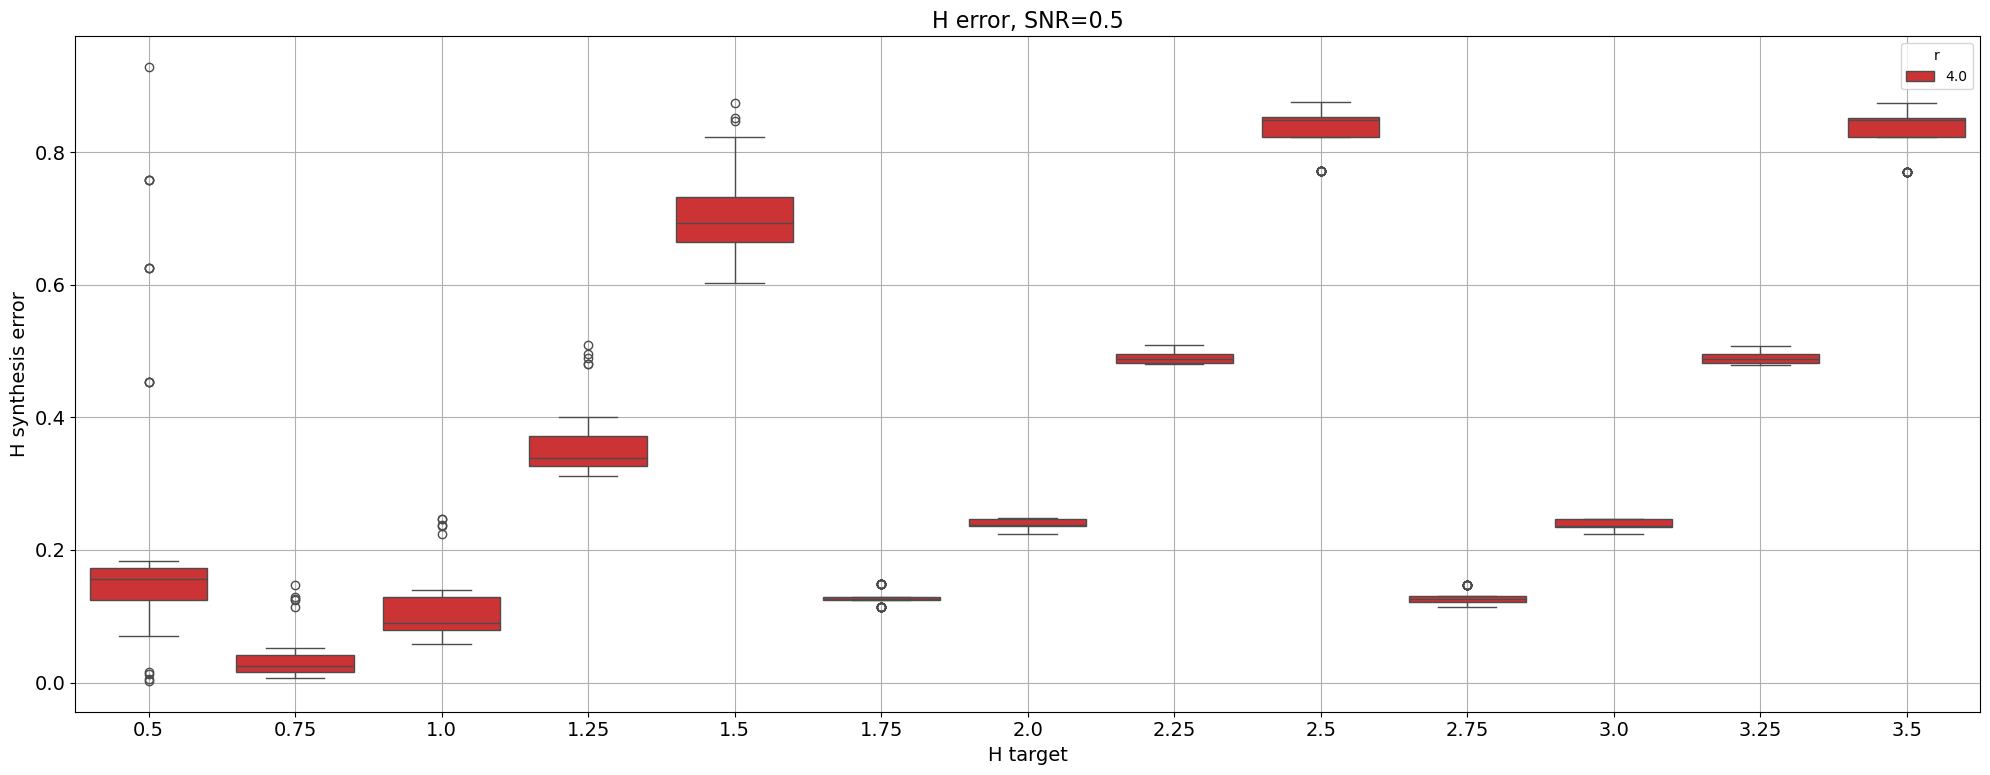

In [24]:
for snr in metrics_df["SNR"].unique():
    plt.figure(figsize=(20, 8))

    part_metrics_df = metrics_df[metrics_df["SNR"] == snr]

    sns.boxplot(x='H_target', y='H_restore_diff', hue='r',  data=part_metrics_df, palette='Set1')
    plt.title(f"H error, SNR={snr}", fontdict={"fontsize": 16})
    plt.suptitle("")
    plt.xlabel("H target", fontsize=14)
    plt.ylabel("H synthesis error", fontsize=14)
    # plt.yscale("log")
    plt.tick_params(labelsize=14)
    plt.tight_layout()
    plt.grid()
    plt.show()

## Experiments Fmatrix

Матрица перехода $F$​ представлена как матрица с нижней диагональю из единиц и соответствующими AR-коэффициентами в первой строке.

$$
F_{k+1|k}^{\text{AR}} =
\begin{bmatrix}
a_1 & a_2 & \cdots & a_{N-1} & a_N \\
1 & 0 & \cdots & 0 & 0 \\
0 & 1 & \cdots & 0 & 0 \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & \cdots & 1 & 0
\end{bmatrix}_{N \times N}
$$

### Noise

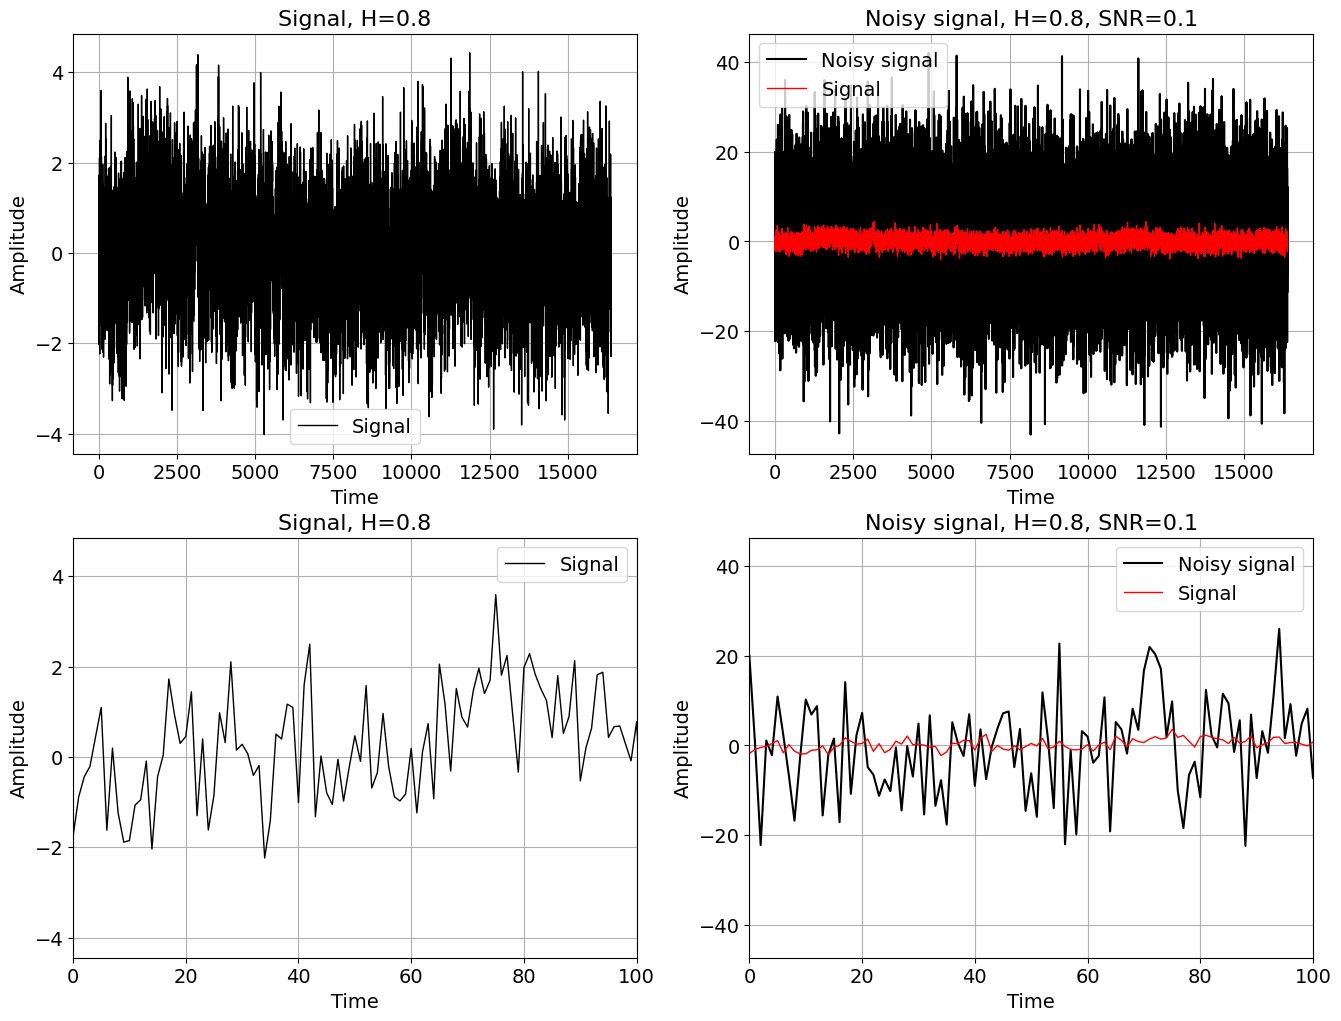

In [13]:
s = TRJ_LEN
h = 0.8
generated_signal = get_signal(h, TRJ_LEN, s)
snr = 0.1
noisy_signal, noise = add_noise(generated_signal, snr)

plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
plt.plot(generated_signal, label="Signal", color="black", linewidth=1)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.tick_params(labelsize=label_fontsize)
plt.grid(True)
plt.title(f"Signal, H={h}", fontdict={"fontsize": title_fontsize})

plt.subplot(2, 2, 2)
plt.plot(noisy_signal, label="Noisy signal", color="black")
plt.plot(
    generated_signal,
    label="Signal",
    color="red",
    linewidth=1,
)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.tick_params(labelsize=label_fontsize)
plt.grid(True)
plt.title(f"Noisy signal, H={h}, SNR={snr}", fontdict={"fontsize": title_fontsize})

plt.subplot(2, 2, 3)
plt.plot(generated_signal, label="Signal", color="black", linewidth=1)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.tick_params(labelsize=label_fontsize)
plt.xlim(0, 100)
plt.grid(True)
plt.title(f"Signal, H={h}", fontdict={"fontsize": title_fontsize})

plt.subplot(2, 2, 4)
plt.plot(noisy_signal, label="Noisy signal", color="black")
plt.plot(
    generated_signal,
    label="Signal",
    color="red",
    linewidth=1,
)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.tick_params(labelsize=label_fontsize)
plt.grid(True)
plt.xlim(0, 100)
plt.title(f"Noisy signal, H={h}, SNR={snr}", fontdict={"fontsize": title_fontsize})
plt.show()

In [14]:
from StatTools.filters.kalman_filter import FractalKalmanFilter
from StatTools.generators.kasdin_generator import create_kasdin_generator

In [27]:
def get_f_matrix(order, ar_filter):
    return np.vstack([ar_filter[1:order+1], np.eye(order)])[:-1]

def get_rmse(signal_a, signal_b, is_mean=True):
    assert len(signal_a) == len(signal_b), (
    "Сигналы должны быть одинаковой длины"
    )

    # RMSE
    if is_mean:
        mse = np.mean((signal_a - signal_b) ** 2)
        return np.sqrt(mse)
    mse = (signal_a - signal_b) ** 2
    return np.sqrt(mse)


In [16]:
generator = create_kasdin_generator(h, length=TRJ_LEN)
ar_filter = generator.get_filter_coefficients()
print(f"AR filter: {ar_filter[0:8]}...{ar_filter[-4:-1]}")

AR filter: [ 1.         -0.3        -0.105      -0.0595     -0.0401625  -0.02972025
 -0.02328086 -0.01895727]...[-7.67759418e-07 -7.67698489e-07 -7.67637568e-07]


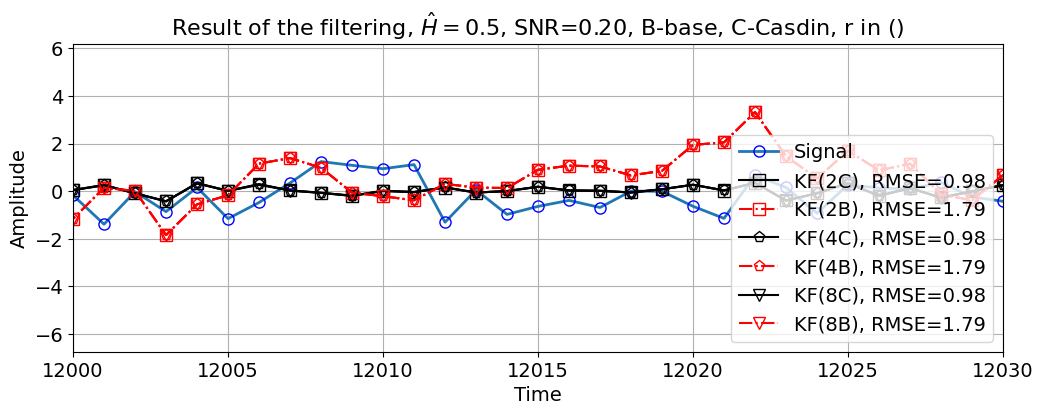

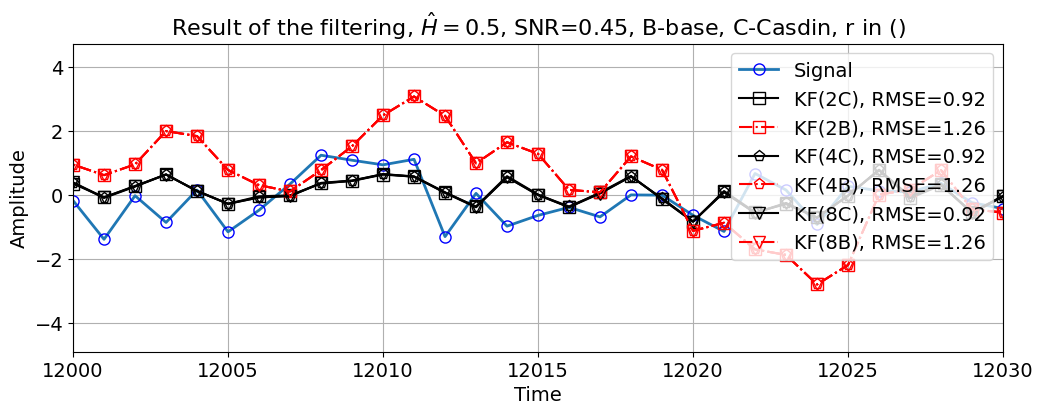

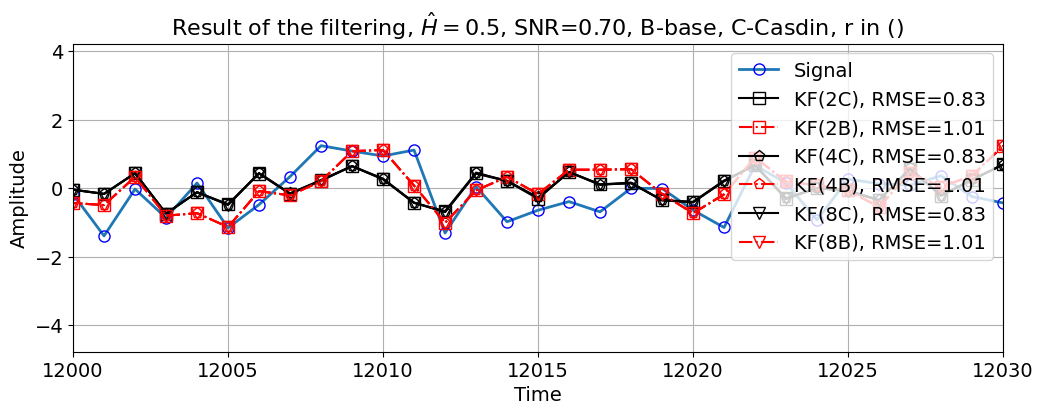

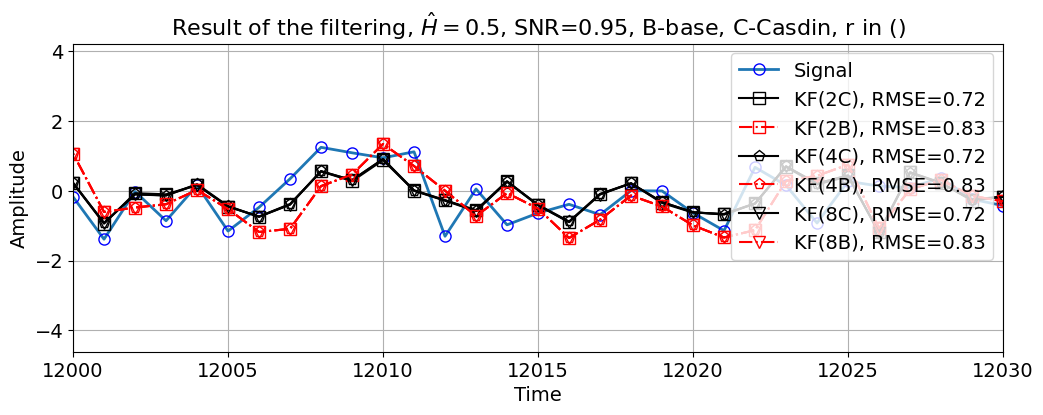

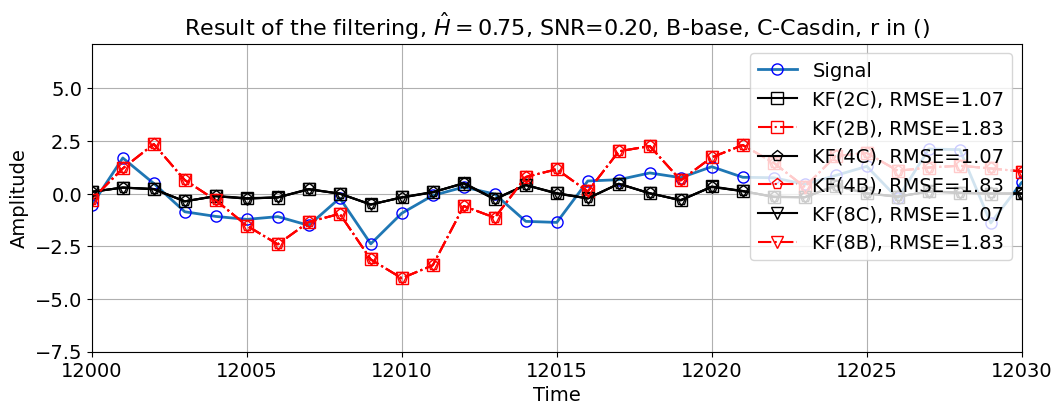

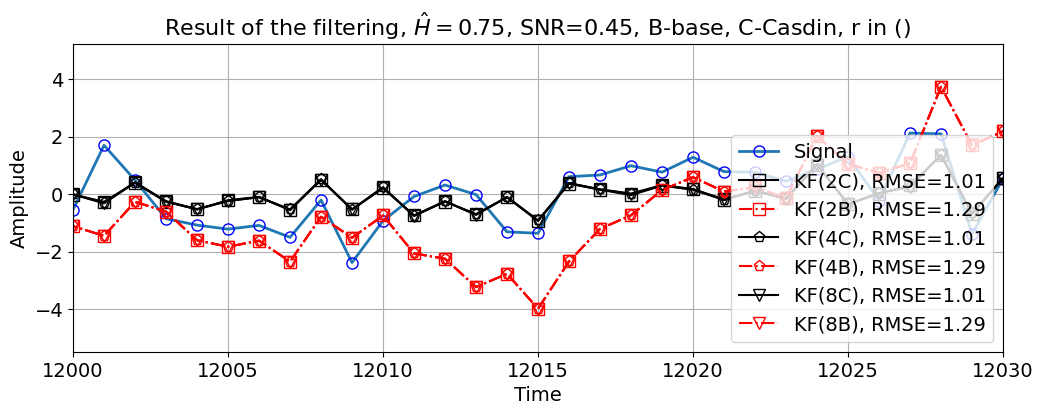

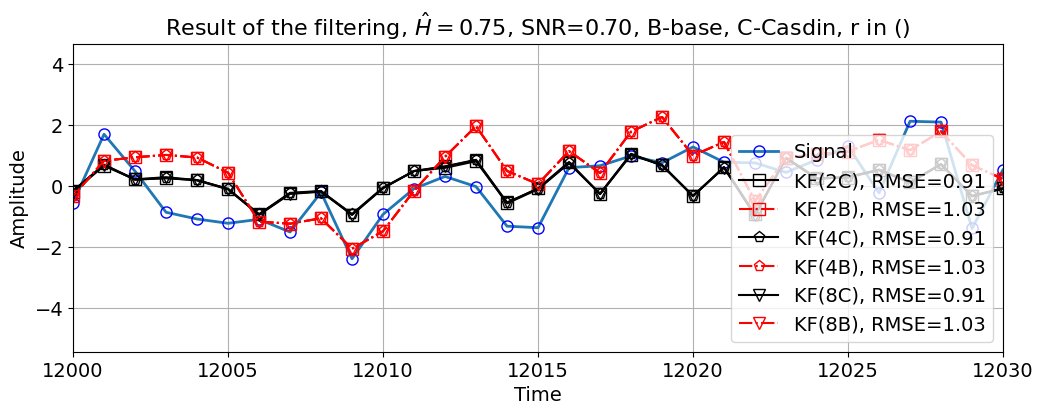

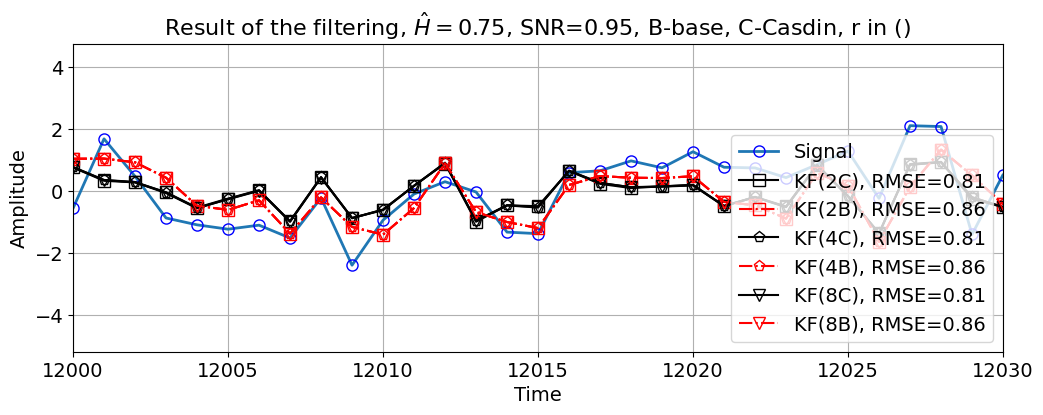

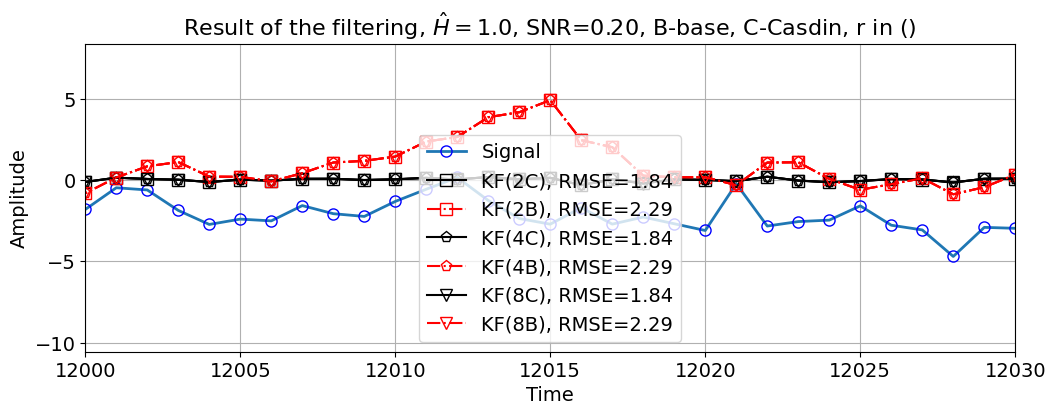

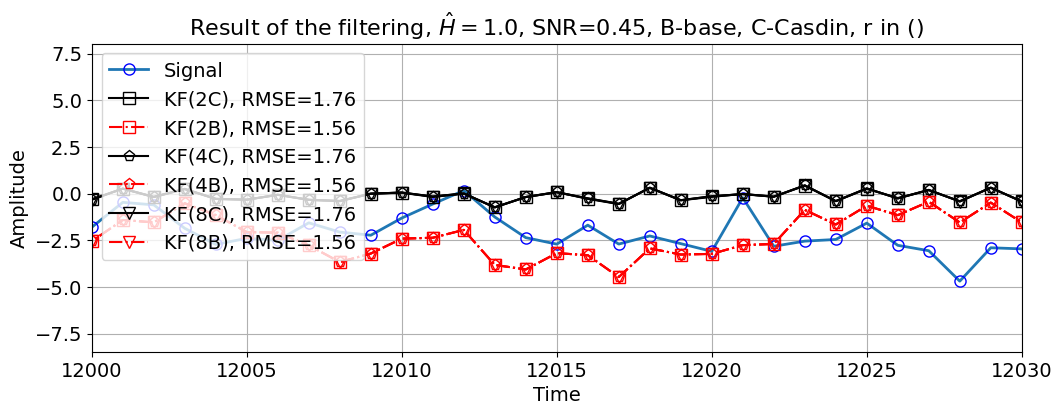

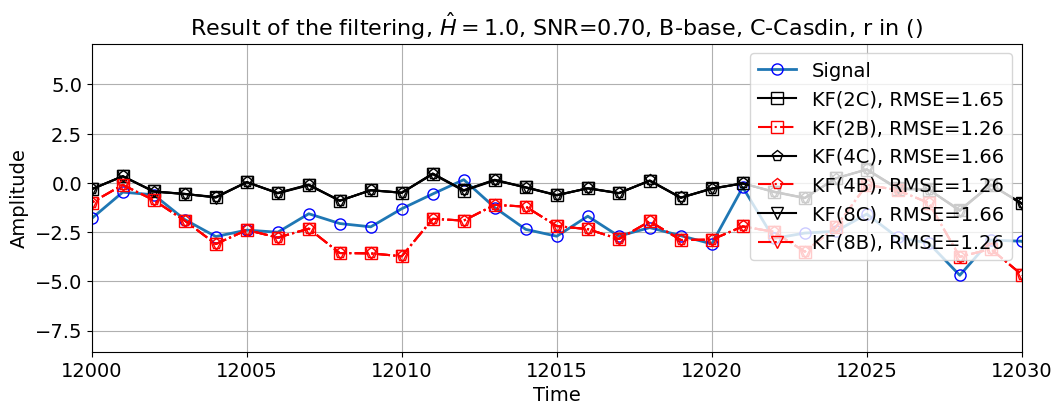

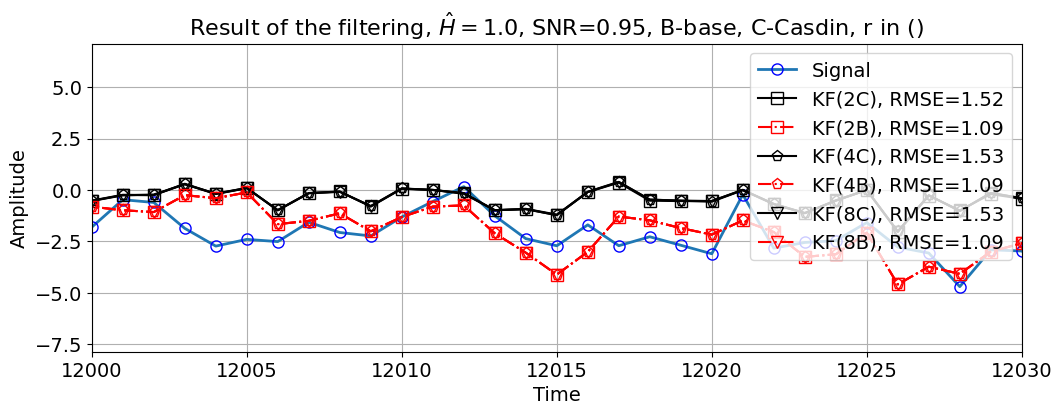

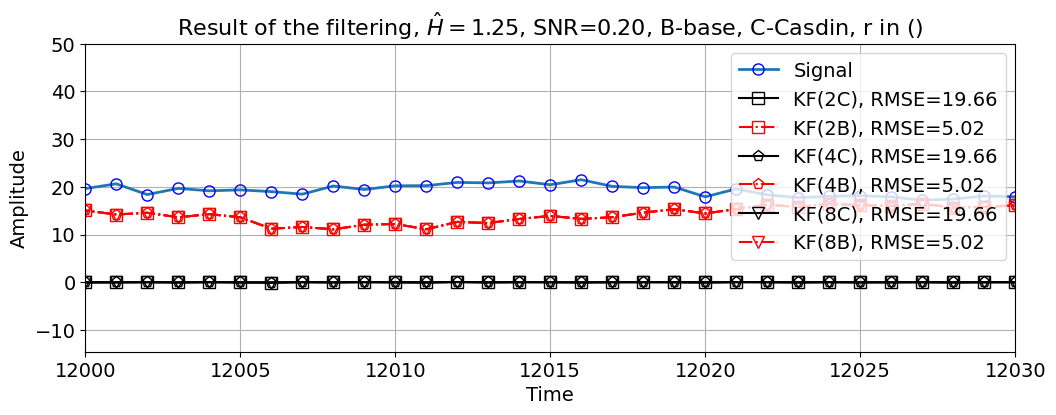

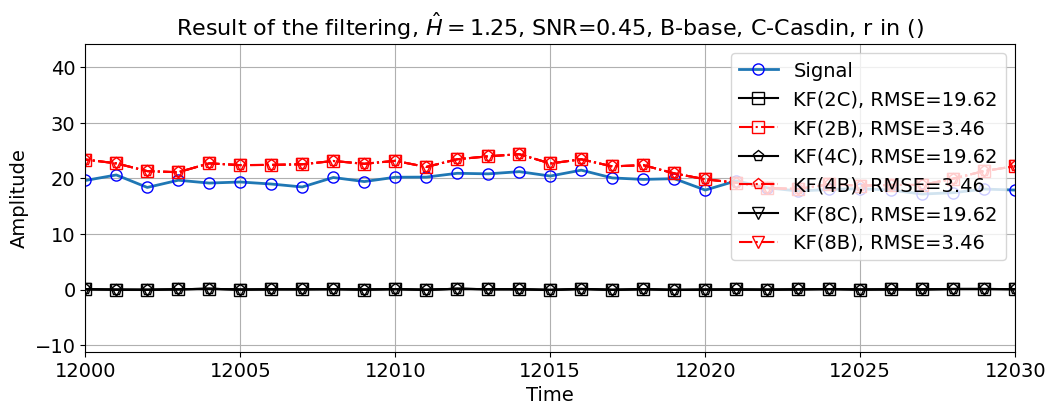

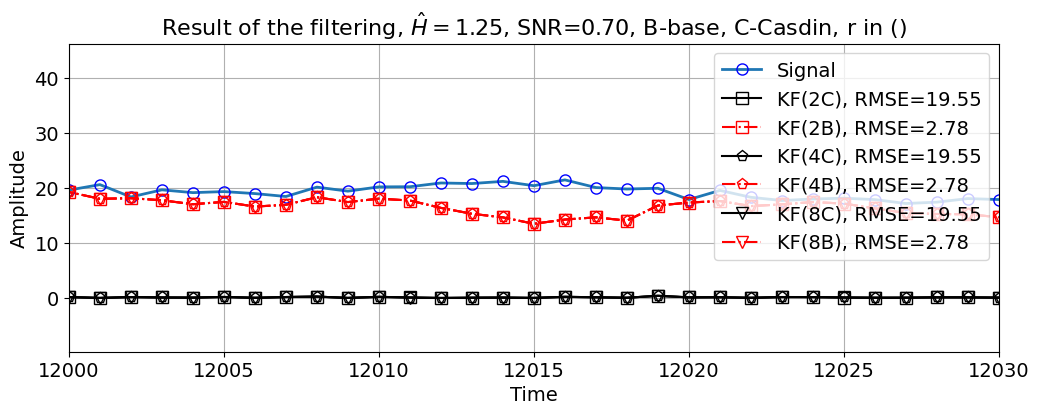

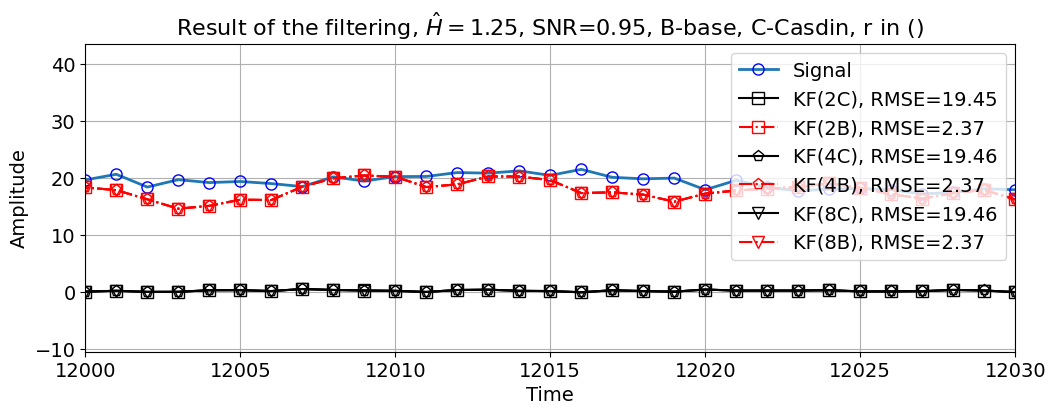

In [ ]:
s = TRJ_LEN
for h in np.arange(0.5, 1.5, 0.25): 
    generated_signal = get_signal(h, TRJ_LEN, s)

    for snr in np.arange(0.2, 1, 0.25):
        noisy_signal, noise = add_noise(generated_signal, snr)
        plt.figure(figsize=(12, 4))
        m = 0
        plt.plot(
            generated_signal,
            markers[m] + "-",
            markerfacecolor="none",  # Пустая середина
            markeredgecolor="blue",  # Цвет границы маркера
            markersize=8,  # Размер маркера
            linewidth=2,
            label="Signal",
        )
        m += 1

        for r in [2, 4, 8]:
            f = FractalKalmanFilter(dim_x=r, dim_z=1)
            f.R = np.std(noise) ** 2
            f.H[0][0] = 1.0
            f.F = get_f_matrix(r, ar_filter)

            estimated_signal = np.zeros(TRJ_LEN)
            for k in range(1, TRJ_LEN):
                f.predict()
                if not np.isnan(noisy_signal[k]):
                    f.update(noisy_signal[k])
                estimated_signal[k] = f.x[0].item()
            rmse = get_rmse(generated_signal, estimated_signal)


            plt.plot(
                estimated_signal,
                markers[m] + "-",
                markerfacecolor="none",  # Пустая середина
                markeredgecolor="black",  # Цвет границы маркера
                markersize=8,  # Размер маркера
                linewidth=1.5,
                color="k",
                label=f"KF({r}C), RMSE={rmse:.2f}",
            )

            f = FractalKalmanFilter(dim_x=r, dim_z=1)
            f.R = np.std(noise) ** 2
            f.H[0][0] = 1.0

            estimated_signal = np.zeros(TRJ_LEN)
            for k in range(1, TRJ_LEN):
                f.predict()
                if not np.isnan(noisy_signal[k]):
                    f.update(noisy_signal[k])
                estimated_signal[k] = f.x[0].item()
            rmse = get_rmse(generated_signal, estimated_signal)

            plt.plot(
                estimated_signal,
                markers[m] + "-.",
                markerfacecolor="none",  # Пустая середина
                markeredgecolor="red",  # Цвет границы маркера
                markersize=8,  # Размер маркера
                linewidth=1.5,
                color="red",
                label=f"KF({r}B), RMSE={rmse:.2f}",
            )
            m += 1


        plt.xlabel("Time", fontsize=axis_fontsize)
        plt.ylabel("Amplitude", fontsize=axis_fontsize)
        plt.xlim(12000, 12030)
        plt.legend(fontsize=legend_fontsize)
        plt.tick_params(labelsize=label_fontsize)
        plt.title(
            f"Result of the filtering, $\\hat{{H}}=${h}, SNR={snr:.2f}, B-base, C-Casdin, r in ()",
            fontdict={"fontsize": title_fontsize},
        )
        plt.grid(True)
        plt.show()

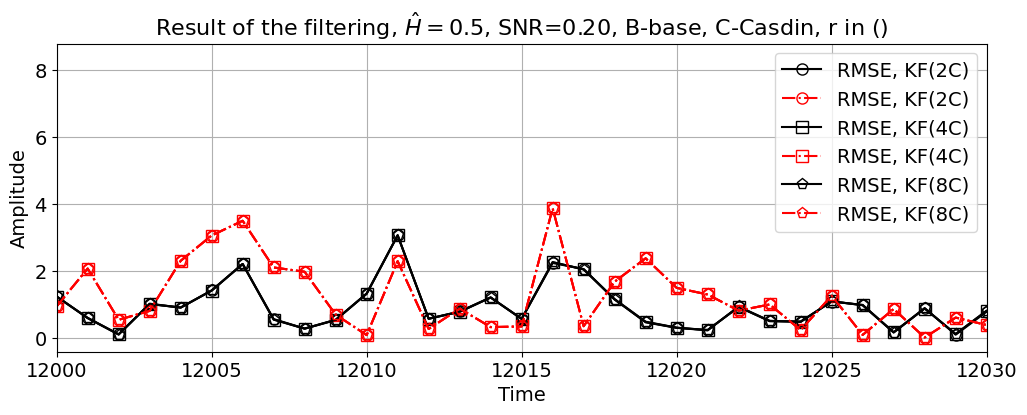

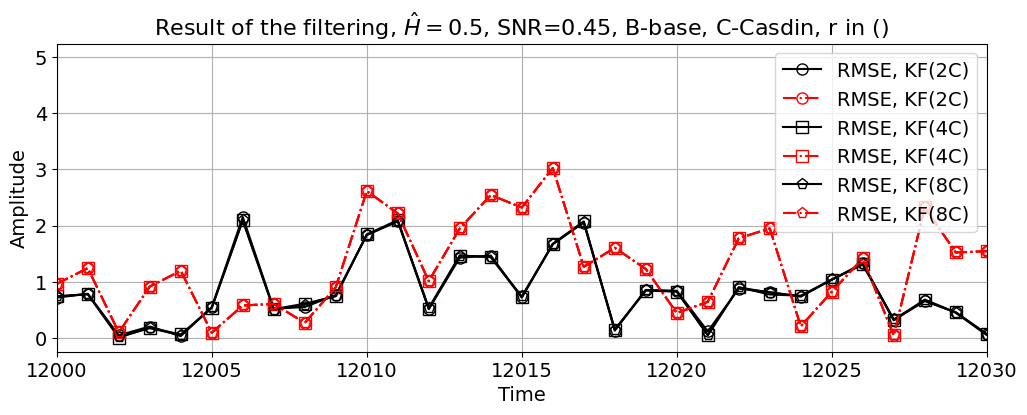

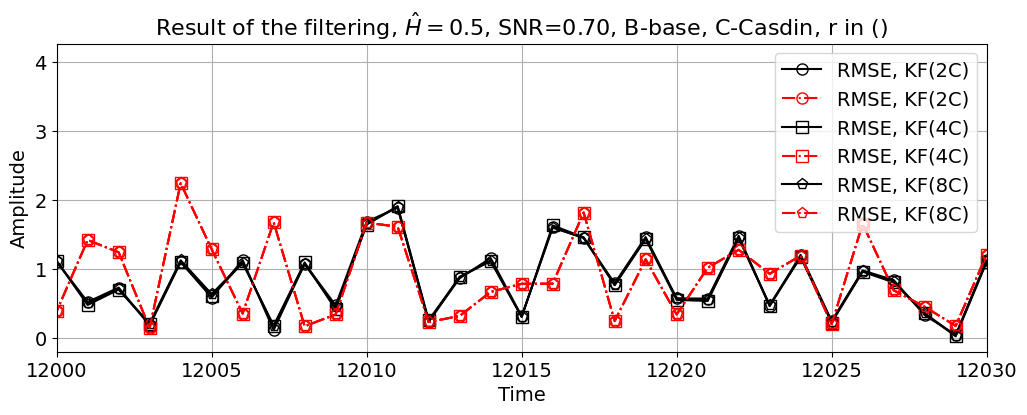

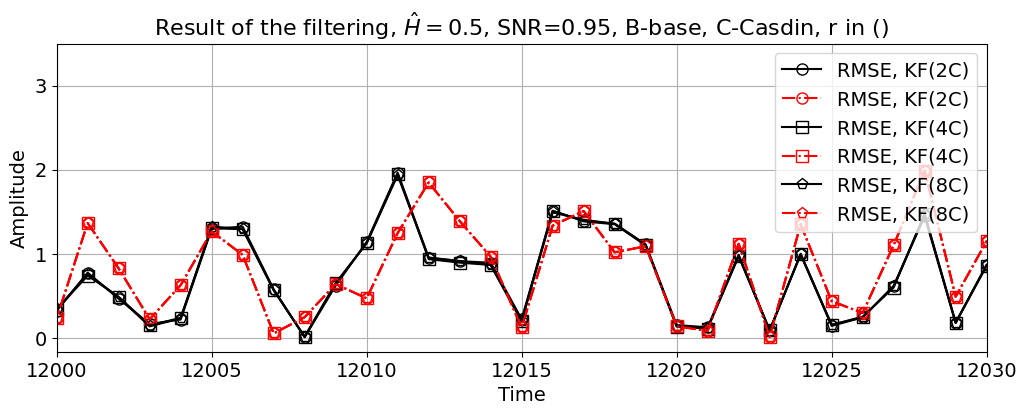

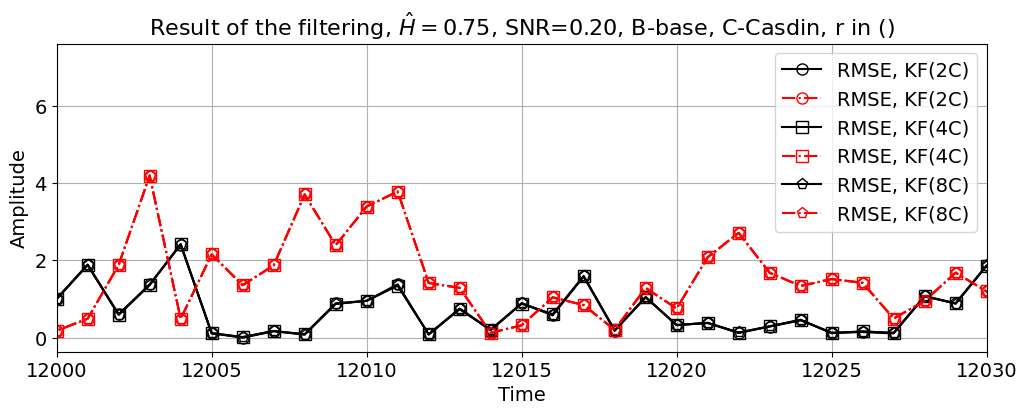

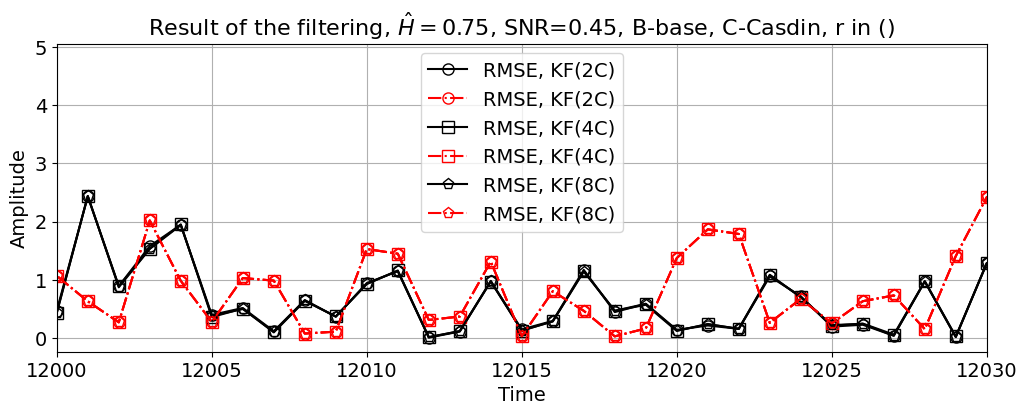

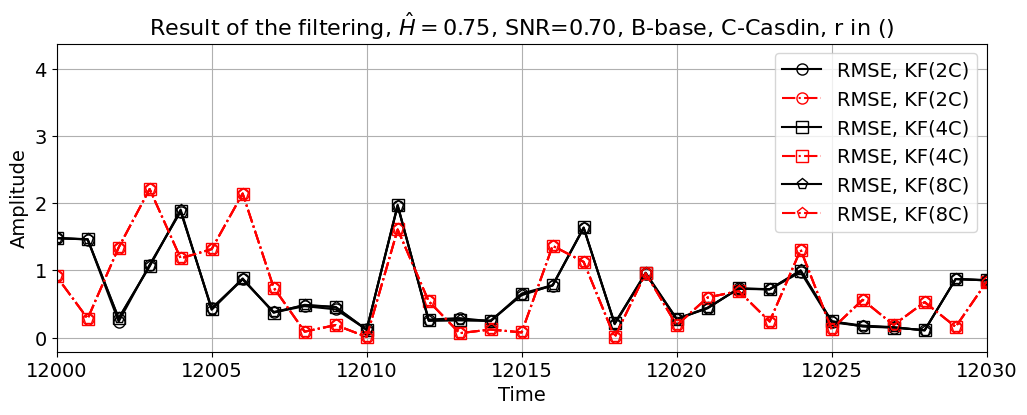

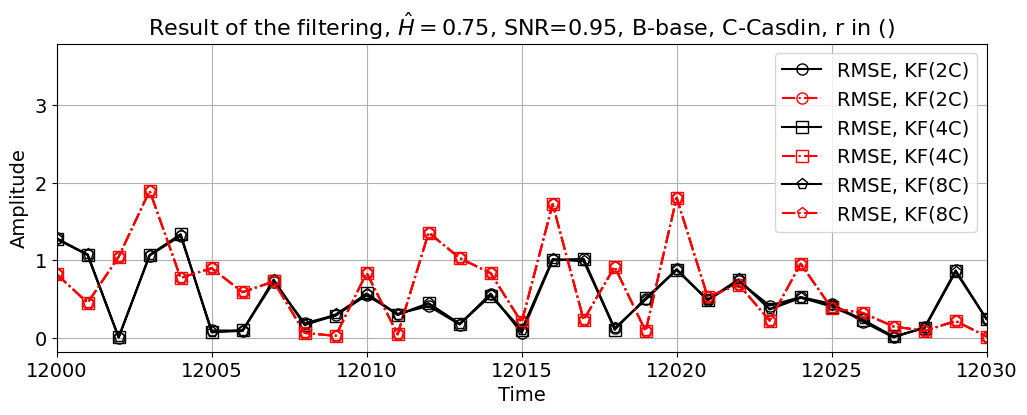

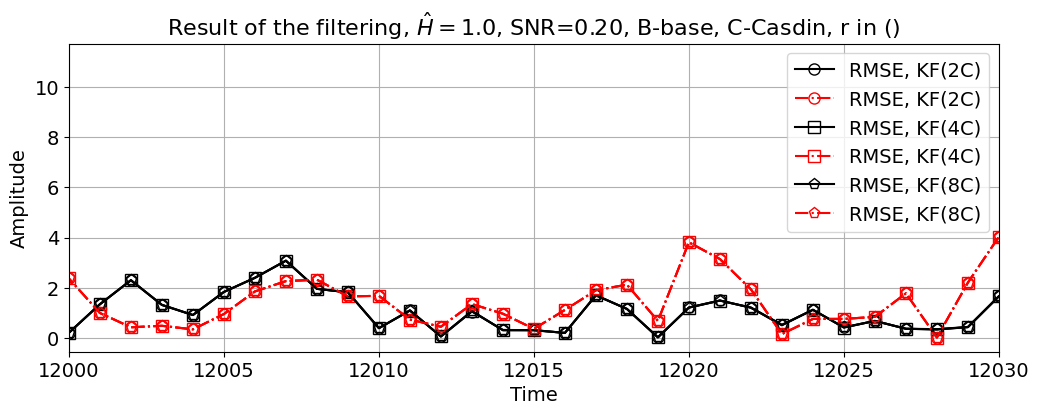

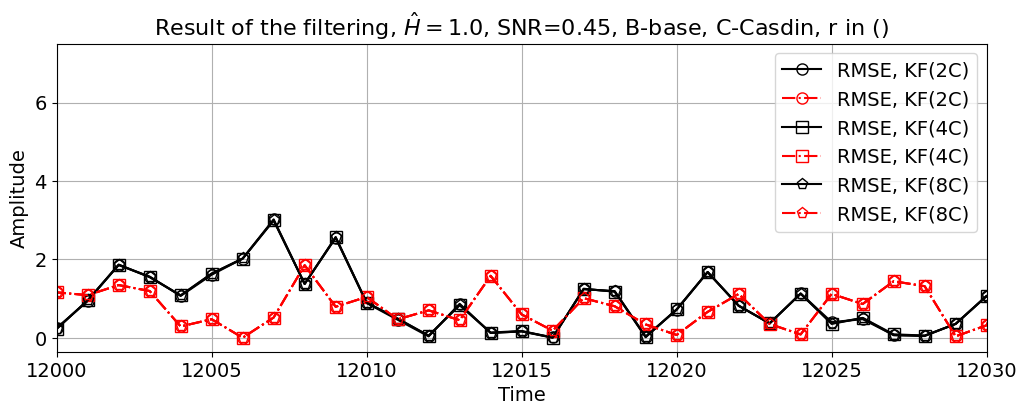

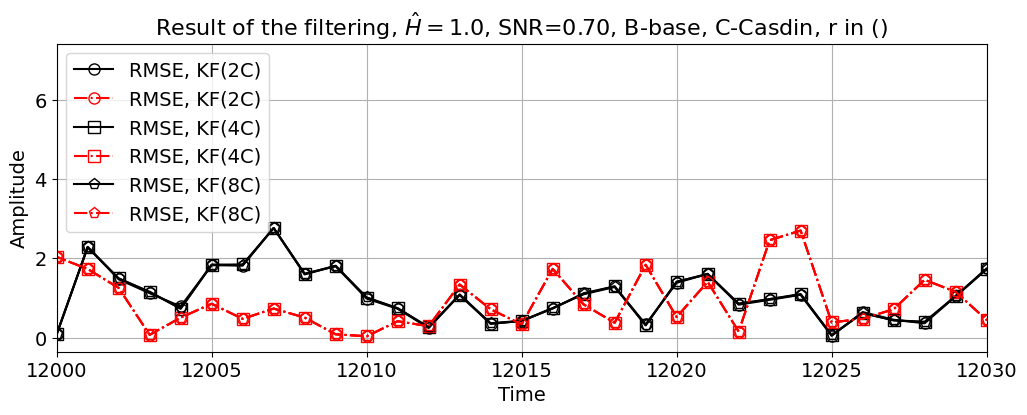

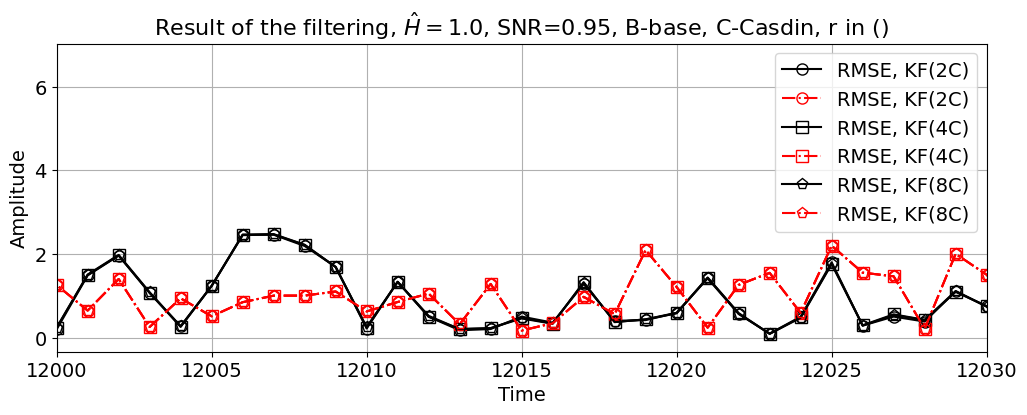

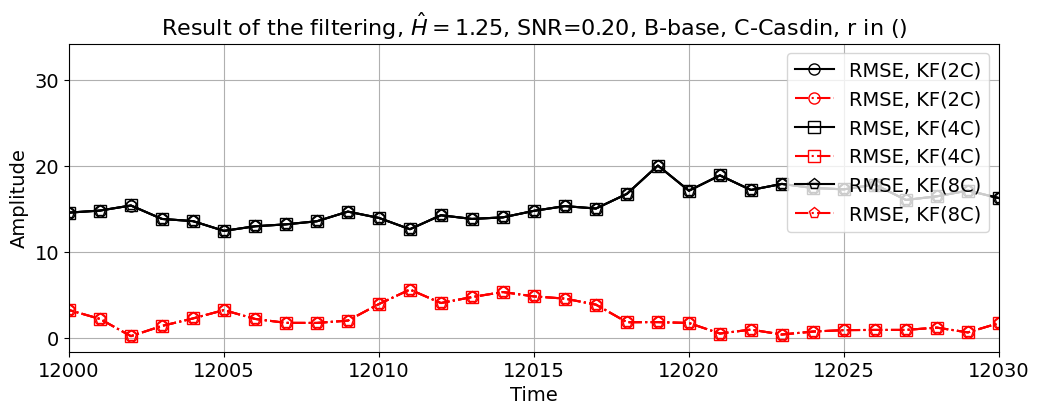

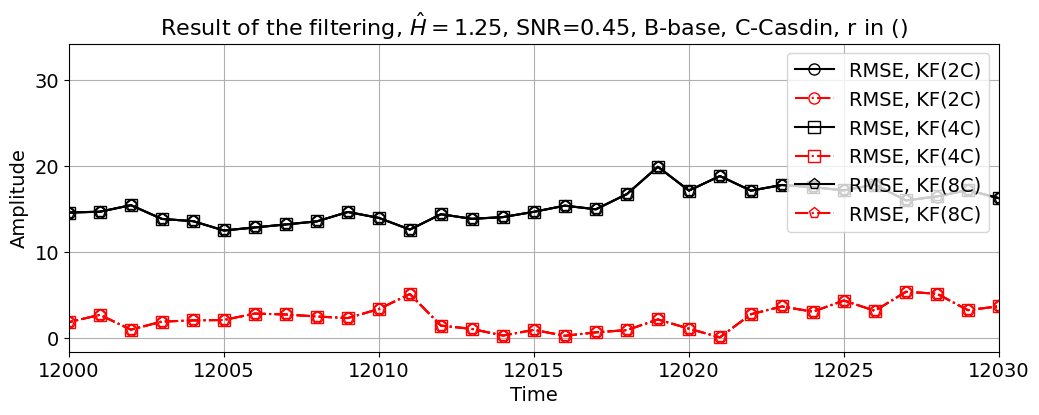

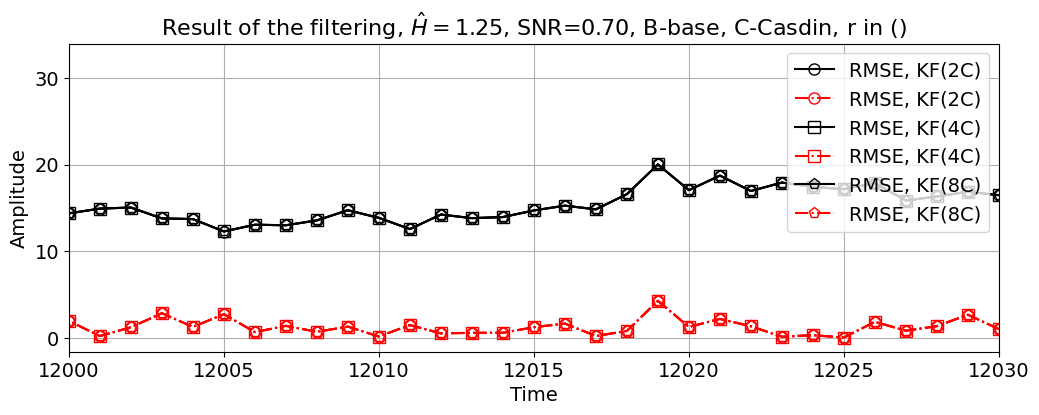

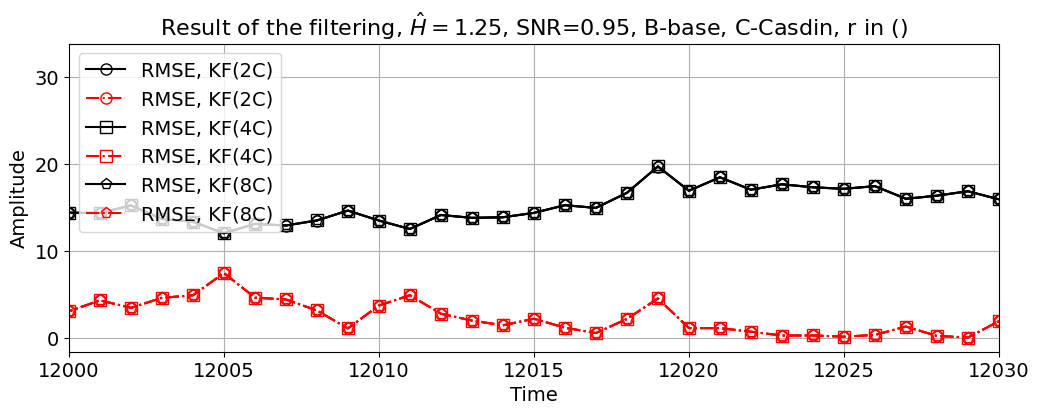

In [30]:
s = TRJ_LEN
for h in np.arange(0.5, 1.5, 0.25): 
    generated_signal = get_signal(h, TRJ_LEN, s)

    for snr in np.arange(0.2, 1, 0.25):
        noisy_signal, noise = add_noise(generated_signal, snr)
        plt.figure(figsize=(12, 4))
        m = 0

        for r in [2, 4, 8]:
            f = FractalKalmanFilter(dim_x=r, dim_z=1)
            f.R = np.std(noise) ** 2
            f.H[0][0] = 1.0
            f.F = get_f_matrix(r, ar_filter)

            estimated_signal = np.zeros(TRJ_LEN)
            for k in range(1, TRJ_LEN):
                f.predict()
                if not np.isnan(noisy_signal[k]):
                    f.update(noisy_signal[k])
                estimated_signal[k] = f.x[0].item()
            rmse = get_rmse(generated_signal, estimated_signal, False)


            plt.plot(
                rmse,
                markers[m] + "-",
                markerfacecolor="none",  # Пустая середина
                markeredgecolor="black",  # Цвет границы маркера
                markersize=8,  # Размер маркера
                linewidth=1.5,
                color="k",
                label=f"RMSE, KF({r}C)",
            )

            f = FractalKalmanFilter(dim_x=r, dim_z=1)
            f.R = np.std(noise) ** 2
            f.H[0][0] = 1.0

            estimated_signal = np.zeros(TRJ_LEN)
            for k in range(1, TRJ_LEN):
                f.predict()
                if not np.isnan(noisy_signal[k]):
                    f.update(noisy_signal[k])
                estimated_signal[k] = f.x[0].item()
            rmse = get_rmse(generated_signal, estimated_signal, False)

            plt.plot(
                rmse,
                markers[m] + "-.",
                markerfacecolor="none",  # Пустая середина
                markeredgecolor="red",  # Цвет границы маркера
                markersize=8,  # Размер маркера
                linewidth=1.5,
                color="red",
                label=f"RMSE, KF({r}C)",
            )
            m += 1


        plt.xlabel("Time", fontsize=axis_fontsize)
        plt.ylabel("Amplitude", fontsize=axis_fontsize)
        plt.xlim(12000, 12030)
        plt.legend(fontsize=legend_fontsize)
        plt.tick_params(labelsize=label_fontsize)
        plt.title(
            f"Result of the filtering, $\\hat{{H}}=${h}, SNR={snr:.2f}, B-base, C-Casdin, r in ()",
            fontdict={"fontsize": title_fontsize},
        )
        plt.grid(True)
        plt.show()